# Heavy-tailed abundance distributions from stochastic Lotka-Volterra model


This code reproduces the results of 
Heavy-tailed abundance distributions from stochastic Lotka-Volterra models
Lana Descheemaeker, Jacopo Grilli and Sophie de Buyl
doi: https://doi.org/10.1101/2021.02.19.431657 

Figure numbers refer to the first version of the article on Biorxiv.
        

In [1]:
savefigures = False

#figures settings are not always optimal for this notebook
#use the command set_presentation_settings() for figures to be adapted for slides (AFTER having loaded the specific imports)
#use the command set_elife_settings() for figures to be adapted for an article format


# Import packages, data and define plot functions

## Standard imports

In [2]:
# Data manipulation
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

import time
np.random.seed(int(time.time()))

import random 
from itertools import count
import warnings

import os

# for plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.patches import Patch
from matplotlib import colorbar as mcolorbar
from matplotlib.lines import Line2D
from itertools import combinations, count

#import matplotlib.font_manager #issue with open sans fonts...

## Specific imports

In [3]:
from python_codes.load_experimental_data import load_experimental_data, load_experimental_abundances
from python_codes.elife_settings import set_elife_settings, ELIFE
from python_codes.presentation_settings import set_presentation_settings, PRESENTATION
from python_codes.kaobook_settings import set_kaobook_settings, KAOBOOK
from enum import Enum

class PROJECT(Enum):
    THESIS = 1
    PRESENTATION = 2
#set_presentation_settings()

In [4]:
set_presentation_settings()

In [53]:
# importing tools to generate the timeseries

from python_codes.noise_parameters import NOISE
from python_codes.models import MODEL
import python_codes.Timeseries_ibm as ibm #key import!
import python_codes.Timeseries_glv as glv #key import!

#and to plot them

from python_codes.timeseries_plotting import PlotTimeseries, PlotRankAbundance# , PlotTimeseriesComparison
from python_codes.triangular_colorbar import abc_to_rgba, plot_legend

#import tool to analyse the timeseries
from python_codes.variation import variation_coefficient, JS
from python_codes.neutrality_analysis import JensenShannon
from python_codes.piecewise_normalizations import PiecewiseLogNorm, PiecewiseNormalize
from python_codes.heavytails import fit_heavytail, plot_heavytail, normalizations, plot_cdf_heavytail

In [17]:
#generate random parameter sets


def random_parameter_set(S, connectance=0.3, minint=-0.5, maxint=0.5,
                         minmigration=0.4, maxmigration=0.4,
                         minextinction=0.5, maxextinction=0.5, growth_rate=1.5):
    interaction = np.random.uniform(minint, maxint, [S, S])
    interaction *= np.random.choice([0, 1], interaction.shape, p=[1 - connectance, connectance])  # connectance
    np.fill_diagonal(interaction, -1.)  # self-interaction

    growth_rate = np.full([S, 1], growth_rate)
    immigration = np.random.uniform(minmigration, maxmigration, [S, 1])
    extinction = np.random.uniform(minextinction, maxextinction, [S, 1])

    params = {'interaction_matrix': interaction, 'immigration_rate': immigration,
              'extinction_rate': extinction, 'growth_rate': growth_rate}

    return params

def random_parameter_set_ibm(S, connectance=0.3, minint=-0.5, maxint=0.5,
                         minmigration=0.4, maxmigration=0.4,
                         minextinction=0.5, maxextinction=0.5, growth_rate=1.5):
    
    interaction = np.random.uniform(minint, maxint, [S, S])
    interaction *= np.random.choice([0, 1], interaction.shape, p=[1 - connectance, connectance])  # connectance
    np.fill_diagonal(interaction, -1.)  # self-interaction

    growth_rate = np.full([S, 1], growth_rate)
    immigration = np.random.uniform(minmigration, maxmigration, [S, 1])
    extinction = np.random.uniform(minextinction, maxextinction, [S, 1])

    SIS = []
    SISfactor = 200

    SISvector = np.ones(S, dtype=int)
    SISvector[SIS] *= SISfactor

    params = {'interaction_matrix' : interaction, 'immigration_rate' : immigration, 
             'extinction_rate' : extinction,
               'growth_rate' : growth_rate, 'SIS':SIS, 'SISvector':SISvector}

    return params


def random_parameter_set_logistic(S, width_growth=1):
    growth_rate = stats.lognorm.rvs(loc=0, s=width_growth, size=[S, 1])
    if np.sqrt(4 - width_growth ** 2) == 0:
        self_int = np.ones(S)
    else:
        self_int = stats.lognorm.rvs(loc=0, s=np.sqrt(4 - width_growth ** 2), size=S)

    interaction = np.zeros([S, S])
    np.fill_diagonal(interaction, -self_int)  # self-interaction

    growth_rate = np.full([S, 1], growth_rate)
    immigration = np.zeros([S, 1])
    extinction = np.zeros([S, 1])

    params = {'interaction_matrix': interaction, 'immigration_rate': immigration,
              'extinction_rate': extinction, 'growth_rate': growth_rate}

    return params

def add_SIS(interaction, SISvector):#todo - not used?
    interaction_SIS = interaction * SISvector
    np.fill_diagonal(interaction_SIS, np.diag(interaction))
    return interaction_SIS

def parameters_to_Zdenko_parameters(interaction, growth_rate, immigration, extinction, SISvector):#todo - not used?
    omega_Z = np.zeros((len(interaction)+1, len(interaction)+1)); 
    omega_Z[1:,1:] = interaction; omega_Z[1:,0] = growth_rate.flatten()
    mu_Z = np.hstack(([0], immigration))
    e_Z = np.hstack(([0], extinction))
    SISvector_Z = np.hstack(([1], SISvector))
    
    return omega_Z, mu_Z, e_Z, SISvector_Z

## Import experimental data

In [18]:
df_ts = load_experimental_data()
df_st = load_experimental_abundances()

## Define plot functions

In [19]:
ticks = { 'JS' : np.linspace(0,1,6),
          'width' : np.logspace(-2,2,5),
          'pval' : [0,0.05,0.25,0.5,0.75,1.0],
        'diff_width' : [-10,-1,-0.1,0,0.1,1,10],
        'filling' : [0.1, 0.1*np.e, 1, np.e, 10],
        'number' : np.linspace(0,100,6),
        'stability' : [-0.1,-0.01,0,0.01,0.1],
                  'diff_JS' : None, 'diff_pval' : None, 'diff_filling' : None, 
                  'diff_number' : None, 'diff_stability' : None
}

labels = {'JS' : 'Jensen Shannon distance', 'width' : 'Width',
            'pval' : 'p-val width', 'filling' : 'Filling degree',
            'number' : 'Percentage remaining species', 'stability' : 'Stability'}
labels = {**labels, **{'diff_' + key : 'Difference ' + value[0].lower() if value[:6] != 'Jensen' else value[0]
                       + value[1:] for key, value in labels.items()}}


def plot_rankabundances(ts, with_experimental=True, ax_ra=None, raw=False, **kwargs):
    if ax_ra == None or ax_s == None:
        fig = plt.figure(figsize=(8, 3))

        ax_ra = fig.add_subplot(1, 2, 1)

    ra = [t.endpoint for label, t in ts.items()]
    labels = list(ts.keys())

    p = PlotRankAbundance(ra, labels=labels, ax=ax_ra, **kwargs)

    s = [fit_heavytail(x.to_numpy().flatten(), func='lognorm')[0] for x in ra]
        
    if with_experimental == True:
        ra_exp = [df_st["Sanger"], df_ts["David_stool_A"].loc[0, :]]
        labels_exp = ["Sanger", "Stool A"]

        for i, r, c in zip(range(len(ra), len(ra)+len(ra_exp)), ra_exp, ['grey', 'black']):
            p = PlotRankAbundance(
                r, labels=labels_exp, ax=ax_ra, color=c, **kwargs)
    
    if not raw and with_experimental == True:
        ax_s.set_xticks(range(len(ra_exp)+len(ra)))
        ax_s.set_xticklabels(labels + labels_exp, rotation=90)
        ax_s.set_xlim([-0.5, len(ra_exp)+len(ra)-0.5])

        ax_ra.set_ylim([1e-5, 1e0])
        ax_ra.set_xlim([0.5, 200])

        ax_ra.legend().remove()
    
    return ax_ra

# TODO combine 3 functions into 1

def plot_distributions(con, T=False, verbose=0):
    df = find_ss_constraints(con, T, verbose=verbose)
    df.reindex()
    df = df[df.label == 'a']

    df.index = range(1, len(df)+1)

    fig = plt.figure(figsize=(15,3))

    for index, row in df.iterrows():
        ax = fig.add_subplot(1, len(df), index)
        
        ra = row['species_1':'species_100'].astype(float).to_numpy().flatten()
        params = fit_heavytail(ra, func='lognorm')
        plot_heavytail(ra, params, ax=ax, func='lognorm', add_label=True)
        ax.set_yscale('log')
        
def stability_mesh(constraints):
    th = 1e-3
    stab = df_constraints(dfs['stability'], constraints).pivot_table(values='median', index='noise', columns='max_cap').to_numpy()
    stab = np.abs(stab); stab[stab < th] = 0; stab *= 3/th; stab[stab > 30] = 30
    return stab

def mscatter(x, y, ax=None, m=None, **kw):
    import matplotlib.markers as mmarkers
    if not ax: ax=plt.gca()
    sc = ax.scatter(x,y,**kw)
    if (m is not None) and (len(m)==len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                        marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)
    return sc

Fitting of lognormal curves, should we consider very low values?

## Function for overview of fits for an abundance distribution

In [20]:
def example_fit_heavytails(d):
    """ fit heavytails 
    input: distribution (numpy array)
    outputs: figure with normal, lognormal and pareto fits
    """
 

    # Define bins.
    bins = np.logspace(-8, -1, 30)
    x_fit = np.logspace(-8, -1, 1000)
    
    # Define figure and axis.
    fig = plt.figure(figsize=(6,3))
    ax = fig.add_subplot(121)
    ax_cdf = fig.add_subplot(122)
    
    # Fit different distributions.
    for dist, ls in zip(['norm', 'lognorm', 'pareto'], [':', '-', '-.']):
        params = fit_heavytail(d, func=dist)
        plot_heavytail(d, params, func=dist, ax=ax, linestyle=ls)
        plot_cdf_heavytail(d, params, func=dist, ax=ax_cdf, linestyle=ls)
        
        print(dist, params[:-1], 'pval ', params[-1])
        
    # Set logscale for axis and bounds.
    ax.set_yscale('log')
    ax.set_ylim([1e-6, 1e2])
    
    # Add colorbar.
    ax_cbar = fig.add_subplot(gs_cbar[0])
    mcolorbar.ColorbarBase(ax_cbar, cmap=plt.cm.coolwarm,
                       orientation='vertical', norm=normalizations['pval'])
    ax_cbar.set_ylabel('p-value Kolmogorov-Smirnov test')
    
    # Add labels.
    ax = fig.add_subplot(gs_tot[:], frameon=False)
    ax.tick_params(axis='both', left=False, labelleft=False,
               bottom=False, labelbottom=False)
    ax.set_xlabel('Relative abundance', ha='right', x=1)
    ax.set_ylabel('Normalized frequency')
    
    # Show figure.
    plt.show()

# Examples of use of the code: generating time series & saving the analysis of a scan over parameters

## Plot one experimental time series

In [21]:
ts_dim = df_ts['David_stool_A'].values[:,1:].shape
ts_dim

(365, 100)

findfont: Font family ['Open Sans'] not found. Falling back to DejaVu Sans.


[26, 19, 63, 77, 51]


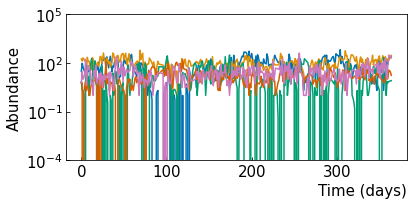

In [22]:
species_selected=random.sample(range(1,ts_dim[1]), 5)
print(species_selected)
d = np.copy(df_ts['David_stool_A'].values[:,species_selected])

fig = plt.figure(figsize=(6,3), tight_layout=True)

ax_ts = fig.add_subplot(111)
vmin = 1e-4; vmax = 1e5

ax_ts.set_ylim([vmin, vmax])

ax_ts.set_yscale('log')

# Labels
ax_ts.set_ylabel('Abundance')

ax_ts.set_xlabel('Time (days)', ha='right', x=1)
ax_ts.plot(d)
if savefigures:
    plt.savefig('stoolA.pdf')
plt.show()


## Test the scanning over parameters (scanheavytails.py) - used to generate the loaded "results"

In [23]:
#see other notebook - testing_scan.ipynb
#in this notebook, we will load the saved analysis of time series via read_df to reproduce the figures 3,4,5,7


## Example of time series with different models

Examples of times series with different models & looking at the effect of time averaging on the width of the abundance distribution

Does taking the time average of the time series makes the abundance distribution less wide? 

It depends on the parameters (noise strength, interaction strength, maximum capacity).

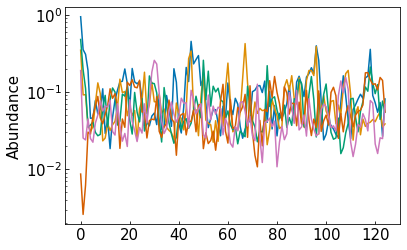

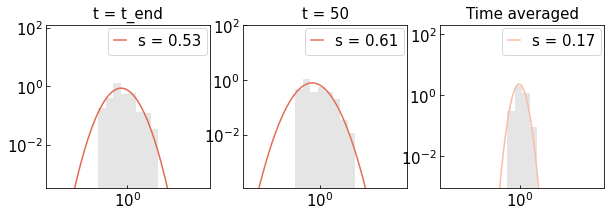

In [24]:
S = 50
migration = 0.3
int_strength = 0.8

params = random_parameter_set(
    S, connectance=0.3, minint=-int_strength, maxint=int_strength,
    minmigration=migration, maxmigration=migration,
    minextinction=0.5, maxextinction=0.5, growth_rate=1.5)

params['maximum_capacity'] = 4.0
params['initial_condition'] = np.random.uniform(0, 1, [S,1])
params['noise_linear'] = 0.8

ts = glv.Timeseries(params, T = 125, dt=0.005, tskip=199, model=MODEL.MAX)

PlotTimeseries(ts.timeseries)

fig = plt.figure(figsize=(10,3))

ax = fig.add_subplot(131)
ax.set_title('t = t_end')
ht_params = fit_heavytail(ts.endpoint.values, func='lognorm')
plot_heavytail(ts.endpoint.values, ht_params, func='lognorm', ax=ax)

ax = fig.add_subplot(132)
ax.set_title('t = 50')
ht_params = fit_heavytail(ts.timeseries.values[50,1:], func='lognorm')
plot_heavytail(ts.timeseries.values[50,1:], ht_params, func='lognorm', ax=ax)

ax = fig.add_subplot(133)
ax.set_title('Time averaged')
ht_params = fit_heavytail(ts.timeseries.iloc[20:,1:].mean(axis=0).values, func='lognorm')
plot_heavytail(ts.timeseries.iloc[20:,1:].mean(axis=0).values, ht_params, func='lognorm', ax=ax)

plt.show()



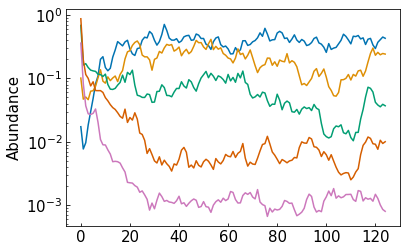

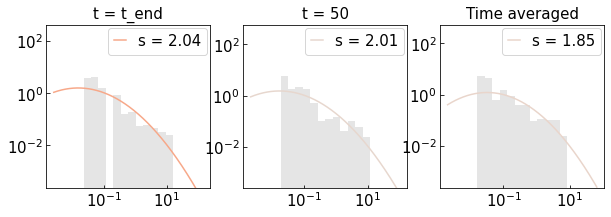

In [25]:
S = 50
migration = 0.001 # 0.01
int_strength = 0.8

params = random_parameter_set(
    S, connectance=0.3, minint=-int_strength, maxint=int_strength,
    minmigration=migration, maxmigration=migration,
    minextinction=0.5, maxextinction=0.5, growth_rate=1.5)

params['maximum_capacity'] = 10.0
params['initial_condition'] = np.random.uniform(0, 1, [S,1])
params['noise_linear'] = 0.2

ts = glv.Timeseries(params, T = 125, dt=0.005, tskip=199, model=MODEL.MAX)

PlotTimeseries(ts.timeseries)

fig = plt.figure(figsize=(10,3))

ax = fig.add_subplot(131)
ax.set_title('t = t_end')
ht_params = fit_heavytail(ts.endpoint.values, func='lognorm')
plot_heavytail(ts.endpoint.values, ht_params, func='lognorm', ax=ax)

ax = fig.add_subplot(132)
ax.set_title('t = 50')
ht_params = fit_heavytail(ts.timeseries.values[50,1:], func='lognorm')
plot_heavytail(ts.timeseries.values[50,1:], ht_params, func='lognorm', ax=ax)

ax = fig.add_subplot(133)
ax.set_title('Time averaged')
ht_params = fit_heavytail(ts.timeseries.iloc[20:,1:].mean(axis=0).values, func='lognorm')
plot_heavytail(ts.timeseries.iloc[20:,1:].mean(axis=0).values, ht_params, func='lognorm', ax=ax)

plt.show()

# Analysis of experimental time series: Figures 1 & 2

## Experimental data (figure 1 A&E)

The rank abundance distribution of experimental data is heavy-tailed, which means that there are many rare species and few abundant ones. 

plankton, human microbiome (gut, palm)


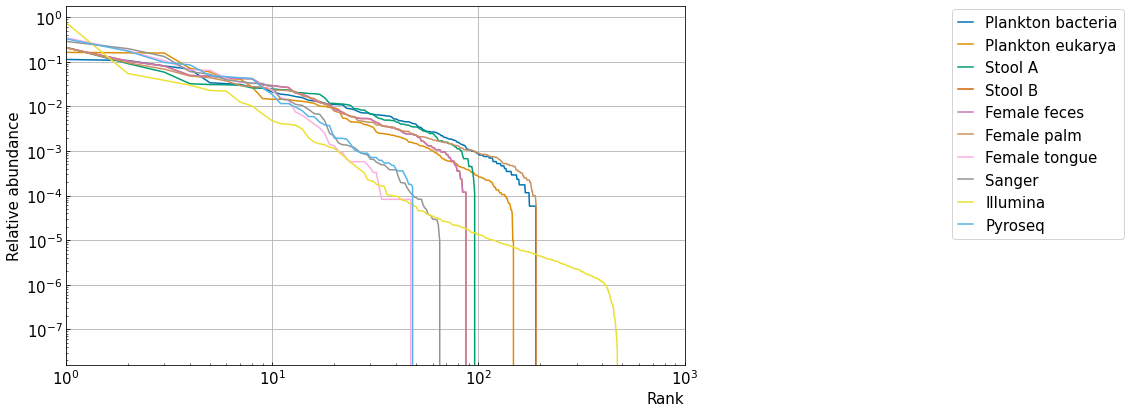

In [26]:
# List of data that will be plotted.
keys = ['plankton_bacteria', 'plankton_eukarya', 'David_stool_A', 'David_stool_B', 
        'Caporaso_F4_feces_L6', 'Caporaso_F4_L_palm_L6', 'Caporaso_F4_tongue_L6', 'Sanger', 'Illumina', 'Pyroseq']

titles = ['Plankton bacteria', 'Plankton eukarya', 'Stool A', 'Stool B', 
          'Female feces', 'Female palm', 'Female tongue', 'Sanger', 'Illumina', 'Pyroseq']


# Define figure and grid for axes.
fig = plt.figure(figsize=(16, 6), tight_layout=True)
gs = gridspec.GridSpec(1,2,width_ratios=[1.5,1]) # left axis for rank abundance, right for legend

ax = fig.add_subplot(gs[0])

# Plot rank abundance curve
for key, title in zip(keys, titles):
    if key in df_ts:
        d = np.copy(df_ts[key].values[0,1:])
    elif key in df_st:
        d = np.copy(df_st[key].values[0,1:])
        
    d /= np.sum(d)
    ax.plot(range(1,len(d)+1), np.sort(d)[::-1], label=title)

# Set logarithmic axes
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim([1,1000])
ax.grid()

# Define axes labels.
ax.set_xlabel('Rank', ha='right', x=1)
ax.set_ylabel('Relative abundance')

# Set legend.
ax_legend = fig.add_subplot(gs[1])
ax_legend.axis('off')
handles, labels = ax.get_legend_handles_labels()
ax_legend.legend(handles, labels, handlelength=1, ncol=1)
if savefigures:
    plt.savefig('16_experimental_rank_abundances.pdf')
plt.show()

We can fit with power law (dash-dotted), exponential (dotted) and lognormal (full line) distributions to the experimental data. The best results are obtained with lognormal data. The other distributions are rejected with a pvalue less than 0.05 for the Kolmogorov Smirnov test.

We therefore opt for a fit to a lognormal curve. The lognormal distribution can be described by

\begin{equation}
\text{pdf}(x) = \frac{1}{s (x - loc) \sqrt{2\pi}} \exp{ \frac{-1}{2} \left(\frac{\ln((x - loc)/scale)}{2 s}\right)^2 }.
\end{equation}

The factor that denotes the width of the distribution in log-scale $s$ is around 2 for experimental data. 

code needed: heavytails.py


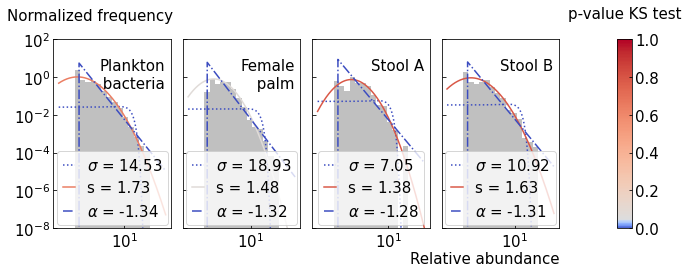

In [27]:
#Figure 1.A -- (and supplementary figure 1)

project = PROJECT.PRESENTATION

# List of data that will be plotted.
if project == PROJECT.THESIS:
    set_elife_settings()
    keys = ['plankton_bacteria', 'plankton_eukarya', 'David_stool_A', 'David_stool_B',
        'Caporaso_F4_L_palm_L6', 'Sanger', 'Illumina', 'Pyroseq']
elif project == PROJECT.PRESENTATION:
    set_presentation_settings()
    keys = ['plankton_bacteria', 'Caporaso_F4_L_palm_L6', 'David_stool_A', 'David_stool_B']

if project == PROJECT.THESIS:
    titles = ['Plankton bacteria', 'Plankton eukarya', 'Stool A', 'Stool B',
          'Female palm', 'Sanger', 'Illumina', 'Pyroseq']
elif project == PROJECT.PRESENTATION:
    titles = ['Plankton\n bacteria', 'Female\n palm', 'Stool A', 'Stool B']

# Define bins.
bins = np.logspace(-8, -1, 30)
x_fit = np.logspace(-8, -1, 1000)

# Define figure and grids for axes.

if project == PROJECT.THESIS:
    fig = plt.figure(figsize=(ELIFE.FULLWIDTH, 4))  # , tight_layout=True)
    gs = gridspec.GridSpec(2, 4, bottom=0.1, top=0.95,
                       left=0.1, right=0.9, wspace=0.1, hspace=0.3)
    gs_cbar = gridspec.GridSpec(1, 1, bottom=0.1, top=0.95, left=0.92, right=0.94)
    gs_tot = gridspec.GridSpec(1, 1, bottom=0.05, top=0.95, left=0.05, right=0.9)

elif project == PROJECT.PRESENTATION:
    fig = plt.figure(figsize=(0.75*PRESENTATION.SLIDEWIDTH, 0.5*PRESENTATION.SLIDEHEIGHT))  # , tight_layout=True)
    gs = gridspec.GridSpec(1, 4, bottom=0.15, top=0.85, left=0.1, right=0.8, wspace=0.1)
    
    gs_cbar = gridspec.GridSpec(1, 1, bottom=0.15, top=0.85, left=0.88, right=0.9)
    gs_tot = gridspec.GridSpec(1, 1, bottom=0.08, top=0.85, left=0.05, right=0.8)

# Plot the abundance distribution and its heavy tails fit for all communities
for i, key, title in zip(range(len(keys)), keys, titles):
    # Define axis and add title.
    ax = fig.add_subplot(gs[i])  
    if project == PROJECT.THESIS:
        ax.set_title(title, y=1.1)
    elif project == PROJECT.PRESENTATION:
        ax.text(x=0.95, y=0.9, s=title, transform=ax.transAxes, ha='right', va='top')
        
    # Get abundance data.
    if key in df_ts:
        d = np.copy(df_ts[key].values[0, 1:])
    elif key in df_st:
        d = np.copy(df_st[key].values[0, 1:])
    
    # Fit different distributions.
    for dist, ls in zip(['norm', 'lognorm', 'pareto'], [':', '-', '-.']):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            
            params = fit_heavytail(d, func=dist)
            plot_heavytail(d, params, func=dist, ax=ax, linestyle=ls)#this is the key line doing the plot
    
    if False:
        # Test whether pareto distribution is more likely than power law or truncated power law.
        pvals = ['%.2E' % params[-1]] # pvalue of pareto
        
        # Add pvalues of power law and truncated power law.
        for dist in ['powerlaw', 'trunc_powerlaw']:
            params = fit_heavytail(d, func=dist)
            pvals += ['%.2E' % params[-1]] # save pvalue for printing
        print(title, "pvals [pareto, powerlaw, truncated powerlaw]", pvals)
    
    # Set logarithmic axis and bounds of axis.
    ax.set_yscale('log')
    ax.set_ylim([1e-8, 1e2])
    ax.legend(loc='lower center')
    
    if i % 4 != 0:
        ax.tick_params(left=True, labelleft=False)

# Add colorbar.
ax_cbar = fig.add_subplot(gs_cbar[0])
mcolorbar.ColorbarBase(ax_cbar, cmap=plt.cm.coolwarm,
                       orientation='vertical', norm=normalizations['pval'])
if project == PROJECT.THESIS:
    ax_cbar.set_ylabel('p-value Kolmogorov-Smirnov test')
if project == PROJECT.PRESENTATION:
    ax_cbar.set_title('p-value KS test', y = 1.08)
# Set x- and y-labels.
ax = fig.add_subplot(gs_tot[:], frameon=False) # axis that combines all axis such that label is shared for all axes
ax.tick_params(axis='both', left=False, labelleft=False,
               bottom=False, labelbottom=False)
ax.set_xlabel('Relative abundance', ha='right', x=1)
ax.set_ylabel('Normalized frequency', y=1.08, labelpad=10, rotation=0, ha='left')

if savefigures:
    plt.savefig('../figures_presentation_experimental.pdf')
plt.show()

We will now plot the width of a fitted lognormal distribution at each time point. The p-value of the KS test for the fit to a lognormal distribution is represented by a color scale (points in blue can be rejected). The width of the lognormal distribution remains between 1 and 3 (grey area).

In [28]:
#this is code to generate the fits to lognormal distributions (results have been saved)
if False:
    file = 'results/experimental/widths_plankton_eukarya.csv' #widths_Caporaso_F4_tongue_L6.csv'#needs to be done for all time series
    
    if os.path.isfile(file):
        os.remove(file)
        
    from heavytails import fit_heavytail

    with open(file, 'a') as f:
        f.write('time,width,loc,scale,stat,pval\n')
        d = np.copy(df_ts['plankton_eukarya'].values[:, 1:])
        for i in range(len(d)):
            f.write('%d' % i)
            
            pars = fit_heavytail(d[i], func='lognorm')
            
            for par in pars:
                f.write(',')
                f.write('%.4E'%par)
            f.write('\n')

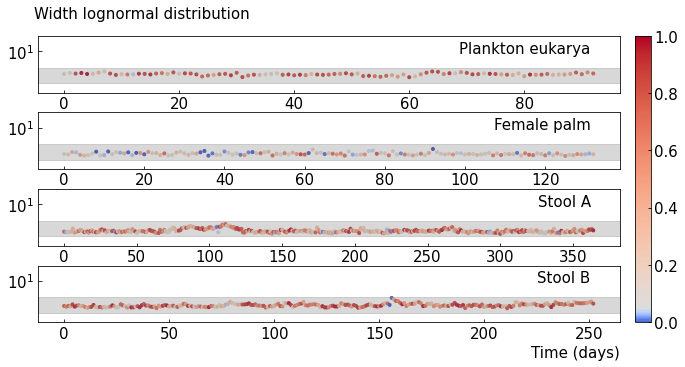

In [29]:
#Figure 1.E -- (and supplementary figure 2)

project = PROJECT.PRESENTATION

# List of data that will be plotted.
keys = ['plankton_eukarya', 'Caporaso_F4_L_palm_L6', 'David_stool_A', 'David_stool_B']
titles = ['Plankton eukarya', 'Female palm', 'Stool A', 'Stool B']

# Define figure and grid for axes.
if project == PROJECT.THESIS:
    fig = plt.figure(figsize=(ELIFE.TEXTWIDTH, 3.))
    gs = gridspec.GridSpec(4,1, hspace=0.3, top=0.95, bottom=0.12, right=0.88)
    gs_cbar = gridspec.GridSpec(1, 1, bottom=0.12, top=0.95, left=0.9, right=0.92)

elif project == PROJECT.PRESENTATION:
    set_presentation_settings()
    fig = plt.figure(figsize=(0.8*PRESENTATION.SLIDEWIDTH, 0.7*PRESENTATION.SLIDEHEIGHT))
    gs = gridspec.GridSpec(4,1, hspace=0.35, top=0.88, bottom=0.12, right=0.88)
    gs_cbar = gridspec.GridSpec(1, 1, bottom=0.12, top=0.88, left=0.9, right=0.92)

# Plot width of lognormal abundance distribution as a function of time for all datasets.
for gsi, f, label in zip(gs, keys, titles):
    ax = fig.add_subplot(gsi)
    ax.text(x=0.95, y=0.8 if project == PROJECT.THESIS else 0.7, s=label, transform=ax.transAxes, ha='right')
    data = pd.read_csv('results/experimental/widths_' + f + '.csv', na_values='NAN')
    ax.scatter(data['time'], data['width'], c=data['pval'], cmap=plt.cm.coolwarm,
                       norm=normalizations['pval'])
    ax.set_yscale('log')
    ax.set_ylim([0.5, 30])
    ax.axhspan(1., 3, alpha=0.3, color='grey')

# Set axes labels.
ax.set_xlabel('Time (days)', x=1, ha='right')
ax = fig.add_subplot(gs[:], frameon=False); # axis that combines all axis for combined label.
ax.tick_params(labelleft=False, labelbottom=False, left=False, bottom=False)
if project == PROJECT.THESIS:
    ax.set_ylabel('Width lognormal distribution', labelpad=20)
elif project == PROJECT.PRESENTATION:
    ax.set_ylabel('Width lognormal distribution', y=1.05, ha='left', rotation=0)
    
# Draw colorbar with pvalue of fit with lognormal distribution.
ax_cbar = fig.add_subplot(gs_cbar[0])
mcolorbar.ColorbarBase(ax_cbar, cmap=plt.cm.coolwarm,
                       orientation='vertical', norm=normalizations['pval'])
if project == PROJECT.THESIS:
    ax_cbar.set_ylabel('p-value KS test for lognormal distribution')

# Save and show plot.
#plt.savefig('../figures_presentation/experimental_time_dependence.pdf')
plt.show()

What happens for the bad fits?

In [30]:
# Which days are bad fits?

#f = 'David_stool_A'
#f = 'plankton_eukarya'
f = 'Caporaso_F4_L_palm_L6'
data = pd.read_csv('results/experimental/widths_' + f + '.csv', na_values='NAN')

data = data[data['pval'] < 0.05]
print(data['time'].values)
#print(data)

[  3   8  10  11  14  16  17  18  20  34  35  36  37  40  44  46  47  61
  65  72  76  77  84  92  99 113 118 121 126 130 131]


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


good day examples
norm (5.681834141646777, 20.134673988731954, 0.3911227391266307) pval  1.60327941054257e-27
lognorm (1.521496190452958, 0.0, 1.0, 0.08511354789313952) pval  0.11027047294743304
pareto (0.27438983010087864, 0, 0.030772863228587504, 0.3239289950365529) pval  8.324956275501095e-19


findfont: Font family ['Open Sans'] not found. Falling back to DejaVu Sans.


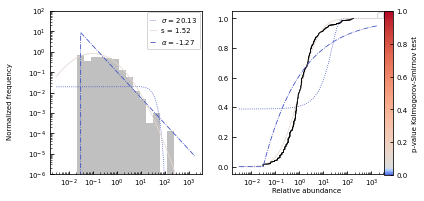

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


norm (4.297996894845962, 11.481060438037767, 0.35819661155415494) pval  5.095432005085798e-23
lognorm (1.4205094898902775, 0.0, 1.0, 0.0860192325363013) pval  0.10369377985663182
pareto (0.3341094170591389, 0, 0.06154573638939431, 0.2985795403202354) pval  5.460707665776161e-16


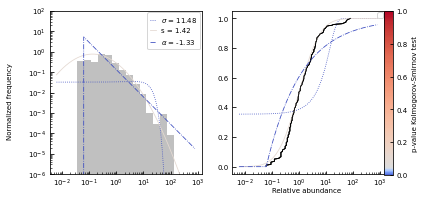

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


norm (4.228282828282829, 15.902742439009048, 0.3958982985550674) pval  4.522099923333517e-28
lognorm (1.482991854696989, 0.0, 1.0, 0.057041030858754116) pval  0.5415604839242872
pareto (0.28370787685189724, 0, 0.030303019361636374, 0.311325104481872) pval  2.7442386667570095e-17


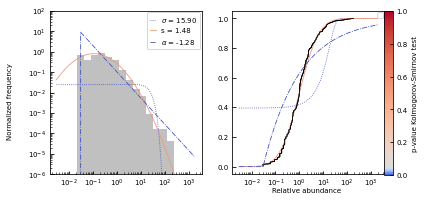

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


bad day examples
norm (9.274871794871792, 42.143723982787854, 0.41336757198393936) pval  1.1400836271732256e-30
lognorm (1.6699421581495406, 0.0, 1.0, 0.10066426239752027) pval  0.03577379603989275
pareto (0.3085170584862583, 0, 0.04999995861840781, 0.28880258442575646) pval  6.775126314583241e-15


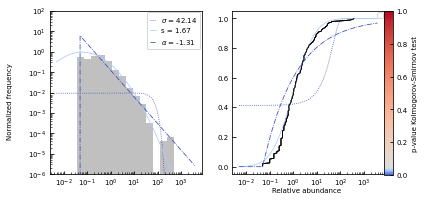

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


norm (10.698969072164946, 44.88630372838158, 0.4063780993067364) pval  1.826651797131782e-29
lognorm (1.6788307190927338, 0.0, 1.0, 0.13278104439332744) pval  0.0019194655209556874
pareto (0.32340589101908146, 0, 0.06666664869388139, 0.26337171191389774) pval  2.299018134926943e-12


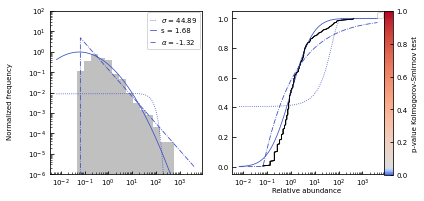

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


norm (3.613960113960115, 8.529498066968365, 0.3369888250585763) pval  1.471533557870366e-20
lognorm (1.4070957404379336, 0.0, 1.0, 0.09625799294404636) pval  0.04765319626091499
pareto (0.2597366778535087, 0, 0.025641021628432493, 0.36513699854315584) pval  3.603816892757738e-24


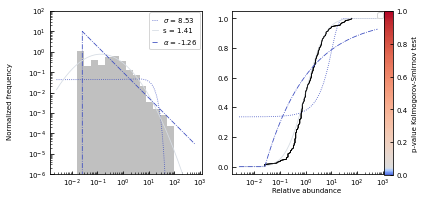

In [31]:
set_elife_settings()

#key = 'David_stool_A'
#good_bad_days = [[0,168, 263], [1,178,293]]

#key = 'plankton_eukarya'
#good_bad_days = [[39], [12]]

key = 'Caporaso_F4_L_palm_L6'
good_bad_days = [[7, 42, 128], [3, 34, 126]]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for label, days in zip(['good', 'bad'], good_bad_days):
        print(label + ' day examples')
        for day in days:
            if key in df_ts:
                d = np.copy(df_ts[key].values[day,1:])

            example_fit_heavytails(d)

## Width s as measure for rank abundance distribution (Figure 2)



The width of the lognormal distribution is a good proxy for the steepness of the rank abundance plot. Larger values of the width $s$ result in steeper curves. We will use this value to measure how well the model approximates the rank abundance curve. From the experimental data we find that the width ranges between 1.57 and 2.78 and we will therefore search for systems with a lognormal distribution with a width between ... and ... 

[ 0.01570897  0.01570897  0.03342304  0.0711122   0.15130119  0.32191451
  0.6849183   1.45725978  3.10052467  6.59680129 14.03562041 14.03562041] [0.         1.73355327 2.03694353 1.53179539 1.79987588 1.01513918
 0.25843986 0.11212415 0.03952412 0.00412811 0.         0.        ]


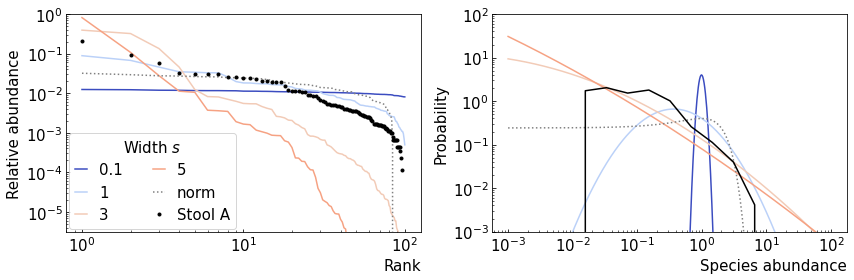

In [32]:
set_presentation_settings()

N=100
fig = plt.figure(figsize=(14, 4))#figsize=(1.5*ELIFE.TEXTWIDTH, 1.5*2), tight_layout=True
ax_s = fig.add_subplot(121)
ax = fig.add_subplot(122)

x_fit = np.logspace(-3, 2, 500)

cmap=plt.cm.coolwarm
norm=normalizations['width']

for s in [0.1, 1, 3, 5]:
    pdf_fitted_log = stats.lognorm.pdf(x_fit, s=s, loc=0, scale=1)
    ax.plot(x_fit, pdf_fitted_log, label=s, color=cmap(norm(s)))
    
    r = stats.lognorm.rvs(s=s, size=N)
    r /= sum(r)
    r = np.sort(r)[::-1]
    ax_s.plot(np.arange(1,N+1), r, label=s, color=cmap(norm(s)))

pdf_fitted_norm = stats.norm.pdf(x_fit, loc=1, scale=1)
ax.plot(x_fit, pdf_fitted_norm, linestyle=':', color='grey', label='norm')

r = stats.norm.rvs(loc=1, scale=1, size=N)
r /= sum(r)
r = np.sort(r)[::-1]
ax_s.plot(np.arange(1,N+1), r, label='norm',linestyle=':', color='grey')

keys = ['David_stool_A']
titles = ['Stool A']

for key, title in zip(keys, titles):
    if key in df_ts:
        d = np.copy(df_ts[key].values[0,1:])
    elif key in df_st:
        d = np.copy(df_st[key].values[0,1:])
        
    d /= np.sum(d); 
    dd = d[d>0]
    dd /= np.mean(dd)
    bins = np.logspace(np.log10(min(dd)), np.log10(max(dd)), 11)
    h, b = np.histogram(dd, bins=bins, density=True)
    x = 10**((np.log10(b[1:]) + np.log10(b[:-1]))/2)
    x = np.append(np.append(x[0], x), x[-1])
    h = np.append(np.append(0, h), 0)
    
    ax.plot(x, h,color='black')
    print(x, h)
    ax_s.plot(range(1,len(d)+1), np.sort(d)[::-1], 'o', 
              label=title, color='black')
    #ax_loc.plot(range(1,len(d)+1), np.sort(d)[::-1], label=title, color='grey')
    
ax_s.set_xscale('log')
ax_s.set_yscale('log')
ax_s.set_ylim([10**(-5.5), 1e0])
ax_s.legend(title='Width $s$', ncol=2)
ax_s.set_xlabel('Rank', x=1, ha='right')
ax_s.set_ylabel('Relative abundance')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-3, 1e2])
ax.set_xlabel('Species abundance', x=1, ha='right')
ax.set_ylabel('Probability')
#ax.legend(title='Width $s$')
if savefigures:
    plt.savefig('width_examples.pdf')
plt.show()

## Measure for noisyness (figure 1B)

Level of noise can make sure that timeseries does not go too far but far enough from equilibrium. What parameter could we use to measure this?

- autocorrelation 
- Jensen Shannon distance between different time steps
- Noise color

The Jensen Shannon distance does not depend on the sampling as do the autocorrelation and noise color, therefore we prefer this JS distance. 

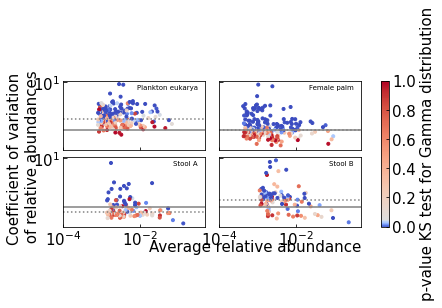

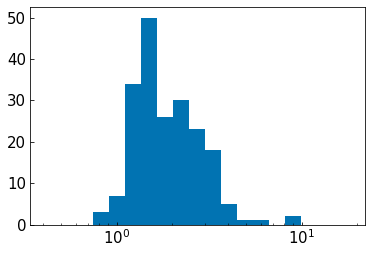

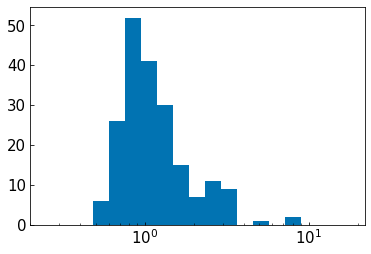

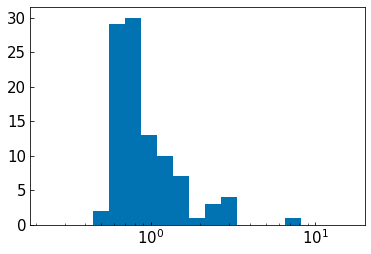

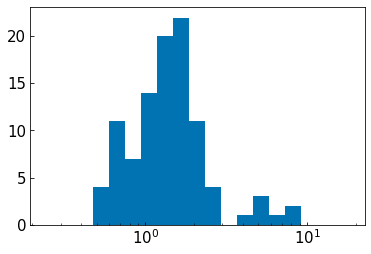

In [50]:
# Variance



fig = plt.figure(figsize=(ELIFE.TEXTWIDTH, 2.5))  # , tight_layout=True)
gs = gridspec.GridSpec(2, 2, bottom=0.12, top=0.93,
                       left=0.1, right=0.85, wspace=0.1, hspace=0.1)
gs_cbar = gridspec.GridSpec(1, 1, bottom=0.12, top=0.93, left=0.9, right=0.92)
gs_tot = gridspec.GridSpec(1, 1, bottom=0.07, top=0.93, left=0.05, right=0.85)

keys = ['plankton_eukarya', 'Caporaso_F4_L_palm_L6', 'David_stool_A', 'David_stool_B']
titles = ['Plankton eukarya', 'Female palm', 'Stool A', 'Stool B']

for i, key, title in zip(range(len(keys)), keys, titles):
    ax = fig.add_subplot(gs[i], sharey=ax if i > 0 else None, sharex=ax if i > 0 else None)
    #ax.set_title(title)
    ax.text(0.95, 0.95, title, 
                ha='right', va='top', fontsize=ELIFE.FONTSIZE, transform = ax.transAxes)
    
    d = df_ts[key].drop('time', axis=1)
    d = d.div(d.sum(axis=1), axis=0)
    
    x = d.mean(axis=0)
    y = d.std(axis=0)/x

    if True:  # Grilli params
        #pval = [stats.kstest(d[species], 'gamma',
        #                     args=((np.mean(d[species])**2/np.var(d[species]), 0,
        #                            np.var(d[species])/np.mean(d[species]))))[1]
        #        for species in d]
        # don't use zeros
        pval = [stats.kstest(d[species][d[species]>0], 'gamma',
                             args=((np.mean(d[species][d[species]>0])**2/np.var(d[species][d[species]>0]), 0,
                                    np.var(d[species][d[species]>0])/np.mean(d[species][d[species]>0]))))[1]
                for species in d]
    else:
        pval = np.empty_like(x)
        for i, species in enumerate(d):
            a_fit, loc_fit, scale_fit = stats.gamma.fit(x,
                                                        np.mean(d[species])**2/np.var(d[species]),
                                                        loc=0, scale=np.var(d[species])/np.mean(d[species]))
            y[i] = a_fit
            pval[i] = stats.kstest(d[species], 'gamma', args=(
                (a_fit, loc_fit, scale_fit)))[1]
            if i % 10 == 0:
                print(a_fit, np.mean(d[species])**2/np.var(d[species]))
                print(pval[i])
    
    plt.figure()
    bins = np.logspace(np.log10(np.min(y)/2), np.log10(np.max(y)*2),20)
    plt.hist(y, bins=bins)
    plt.xscale('log')
    
    ax.scatter(x, y, c=pval, cmap='coolwarm',
               norm=normalizations['pval'])  # color='grey')

    x_fit = np.logspace(np.log10(np.nanmin(x[x > 0])/2),
                        np.log10(np.nanmax(x[x > 0])*2), 100)
    ax.axhline(y=np.median(y), linestyle=':', color='grey')
    ax.axhline(y=1, linestyle='-', color='grey')

    #r2 = r2_score(y, x)
    #ax.text(0.9, 0.1, '%.2f' % r2, ha='right', fontsize=10, transform = ax.transAxes)

    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim([x_fit[0], x_fit[-1]])
    if i % 2 != 0:
        ax.tick_params(labelleft=False)
    if i < 2:
        ax.tick_params(labelbottom=False)
    
ax.set_xlim([1e-4,5e-1])
ax_cbar = fig.add_subplot(gs_cbar[0])
mcolorbar.ColorbarBase(ax_cbar, cmap=plt.cm.coolwarm,
                       orientation='vertical', norm=normalizations['pval'])

ax_cbar.set_ylabel('p-value KS test for Gamma distribution')
ax = fig.add_subplot(gs_tot[:], frameon=False)
ax.tick_params(axis='both', left=False, labelleft=False,
               bottom=False, labelbottom=False)
ax.set_xlabel('Average relative abundance', ha='right', x=1)
ax.set_ylabel('Coefficient of variation\n of relative abundances')

#fig.savefig('figures/experimental_variation.pdf')
plt.show()

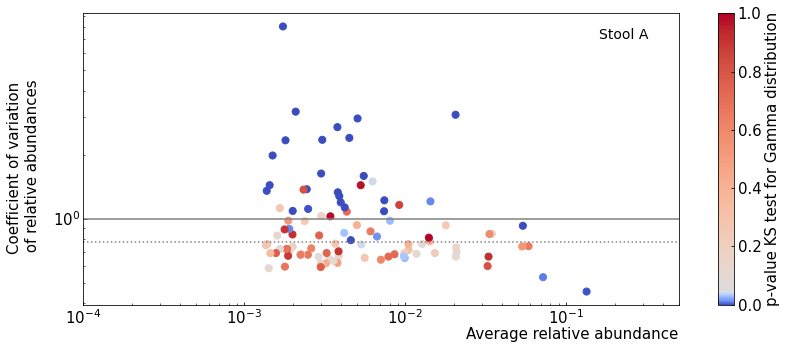

In [51]:
# Extra figure for presentation #todo remove Variance



fig = plt.figure(figsize=(ELIFE.TEXTWIDTH*2, 2*2.5), tight_layout=True)  # )
gs = gridspec.GridSpec(1, 1, bottom=0.12, top=0.93,
                       left=0.1, right=0.85, wspace=0.1, hspace=0.1)
gs_cbar = gridspec.GridSpec(1, 1, bottom=0.12, top=0.93, left=0.9, right=0.92)
gs_tot = gridspec.GridSpec(1, 1, bottom=0.07, top=0.93, left=0.05, right=0.85)

key = ['David_stool_A']
title = 'Stool A'

ax = fig.add_subplot(gs[0])
#ax.set_title(title)
ax.text(0.95, 0.95, title, 
            ha='right', va='top', fontsize=14, transform = ax.transAxes)

d = df_ts['David_stool_A'].drop('time', axis=1)
d = d.div(d.sum(axis=1), axis=0)

x = d.mean(axis=0)
y = d.std(axis=0)/x

if True:  # Grilli params
    #pval = [stats.kstest(d[species], 'gamma',
    #                     args=((np.mean(d[species])**2/np.var(d[species]), 0,
    #                            np.var(d[species])/np.mean(d[species]))))[1]
    #        for species in d]
    # don't use zeros
    pval = [stats.kstest(d[species][d[species]>0], 'gamma',
                         args=((np.mean(d[species][d[species]>0])**2/np.var(d[species][d[species]>0]), 0,
                                np.var(d[species][d[species]>0])/np.mean(d[species][d[species]>0]))))[1]
            for species in d]
else:
    pval = np.empty_like(x)
    for i, species in enumerate(d):
        a_fit, loc_fit, scale_fit = stats.gamma.fit(x,
                                                    np.mean(d[species])**2/np.var(d[species]),
                                                    loc=0, scale=np.var(d[species])/np.mean(d[species]))
        y[i] = a_fit
        pval[i] = stats.kstest(d[species], 'gamma', args=(
            (a_fit, loc_fit, scale_fit)))[1]
        if i % 10 == 0:
            print(a_fit, np.mean(d[species])**2/np.var(d[species]))
            print(pval[i])

bins = np.logspace(np.log10(np.min(y)/2), np.log10(np.max(y)*2),20)
#plt.hist(y, bins=bins)
plt.xscale('log')

ax.scatter(x, y, c=pval,s=50,cmap='coolwarm',
           norm=normalizations['pval'])  # color='grey')

x_fit = np.logspace(np.log10(np.nanmin(x[x > 0])/2),
                    np.log10(np.nanmax(x[x > 0])*2), 100)
ax.axhline(y=np.median(y), linestyle=':', color='grey')
ax.axhline(y=1, linestyle='-', color='grey')

#r2 = r2_score(y, x)
#ax.text(0.9, 0.1, '%.2f' % r2, ha='right', fontsize=10, transform = ax.transAxes)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([x_fit[0], x_fit[-1]])
#ax.tick_params(labelleft=False)

#ax.tick_params(labelbottom=False)
  
ax.set_xlim([1e-4,5e-1])
ax_cbar = fig.add_subplot(gs_cbar[0])
mcolorbar.ColorbarBase(ax_cbar, cmap=plt.cm.coolwarm,
                       orientation='vertical', norm=normalizations['pval'])

ax_cbar.set_ylabel('p-value KS test for Gamma distribution')
ax = fig.add_subplot(gs_tot[:], frameon=False)
ax.tick_params(axis='both', left=False, labelleft=False,
               bottom=False, labelbottom=False)
ax.set_xlabel('Average relative abundance', ha='right', x=1)
ax.set_ylabel('Coefficient of variation\n of relative abundances')

if savefigures:
    fig.savefig('experimental_variation.pdf')
plt.show()

1.6336098827894223 1.850240195962073


Text(0, 0.5, 'Probability')

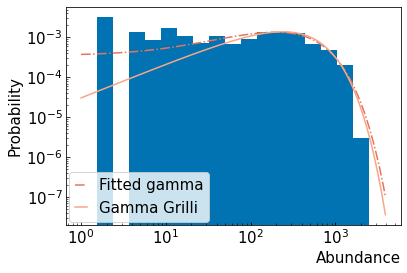

In [35]:
keys = ['plankton_eukarya', 'David_stool_A', 'Caporaso_F4_L_palm_L6', 'Caporaso_F4_tongue_L6']

d = df_ts[keys[1]]

x = d.species_3.to_numpy()
a_fit, loc_fit, scale_fit = stats.gamma.fit(x)

x_fit = np.logspace(np.log10(.5*np.min(x[x>0])), np.log10(2*np.max(x)), 100)
bins = np.logspace(np.log10(.5*np.min(x[x>0])), np.log10(2*np.max(x)), 20)

plt.hist(x, density=True, bins=bins)

norm=normalizations['pval']

print(a_fit, (np.mean(x)**2/np.var(x)))

for a, loc, scale, ls, label in zip([a_fit, (np.mean(x)**2/np.var(x))],
                             [loc_fit, 0],
                             [scale_fit, np.var(x)/np.mean(x)],
                             ['-.', '-'],
                             ['Fitted gamma', 'Gamma Grilli']):
    stat, pval = stats.kstest(x, 'gamma', args=((a, loc, scale)))
    plt.plot(x_fit, stats.gamma.pdf(x_fit, a, loc, scale), c=plt.cm.coolwarm(norm(pval)),  
             linestyle=ls, label=label)
    
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.xlabel('Abundance', x=1, ha='right')
plt.ylabel('Probability')

1.6336098827894223 1.850240195962073


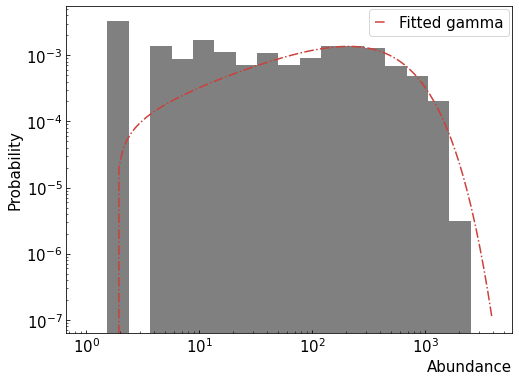

In [36]:
#extra to be removed #todo remove

fig = plt.figure(figsize=(8,6))
keys = ['plankton_eukarya', 'David_stool_A', 'Caporaso_F4_L_palm_L6', 'Caporaso_F4_tongue_L6']

d = df_ts[keys[1]]

x = d.species_3.to_numpy()
a_fit, loc_fit, scale_fit = stats.gamma.fit(x)

x_fit = np.logspace(np.log10(.5*np.min(x[x>0])), np.log10(2*np.max(x)), 100)
bins = np.logspace(np.log10(.5*np.min(x[x>0])), np.log10(2*np.max(x)), 20)

plt.hist(x, color="grey",density=True, bins=bins)

norm=normalizations['pval']

print(a_fit, (np.mean(x)**2/np.var(x)))

a=a_fit
loc = np.mean(x)**2/np.var(x)
scale = scale_fit
ls='-.'
label='Fitted gamma'
stat, pval = stats.kstest(x, 'gamma', args=((a, loc, scale)))
plt.plot(x_fit, stats.gamma.pdf(x_fit, a, loc, scale), c=plt.cm.coolwarm(norm(pval)),  
         linestyle=ls, label=label)
    
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.xlabel('Abundance', x=1, ha='right')
plt.ylabel('Probability')
if savefigures:
    plt.savefig('ex_gamma.pdf')

(1.0, 3892.000000000001)

<Figure size 864x864 with 0 Axes>

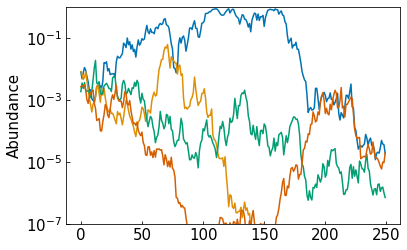

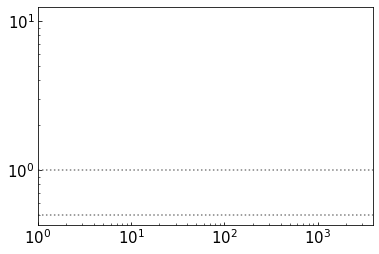

In [37]:
def random_parameter_set(S, connectance=0.3, minint=-0.5, maxint=0.5, 
                         minmigration=0.4, maxmigration=0.4, 
                         minextinction=0.3, maxextinction=0.3):
    interaction = np.random.uniform(minint,maxint, [S, S])
    interaction *= np.random.choice([0, 1], interaction.shape, p=[1-connectance, connectance]) # connectance
    np.fill_diagonal(interaction, -1.) # self-interaction
    
    growth_rate = np.full([S,1], 0.3)
    immigration = np.random.uniform(minmigration,maxmigration, [S,1]);
    extinction = np.random.uniform(minextinction,maxextinction, [S,1]); 
    
    return interaction, growth_rate, immigration, extinction

S = 200        # species in metacommunity
s = None      # species in local community
SIS = []
SISfactor = 200
sites = 10000

SISvector = np.ones(S, dtype=int)
SISvector[SIS] *= SISfactor

migration = 0
connectance = 0.1
minint = -0.1; maxint = 0.1

fig_ra = plt.figure(figsize=(12,12))
gs_ra = gridspec.GridSpec(3,3)

interaction, growth_rate, immigration, extinction = random_parameter_set(S, 
             minmigration=migration, maxmigration=migration, connectance=connectance,
             minint=minint, maxint=maxint)
initcond = np.random.uniform(0, 10, [S,1])
#np.fill_diagonal(interaction, np.random.uniform(-10,-1, len(interaction)))

params = {'interaction_matrix' : interaction, 'immigration_rate' : immigration, 
                          'extinction_rate' : extinction, 'initial_condition' : initcond, 
              'noise_linear' : 0.5, 'growth_rate' : growth_rate}
            
ts = glv.Timeseries(params, T = 250, dt=0.01, tskip=99).timeseries
ts.set_index('time', inplace=True)
ts = ts.div(ts.sum(axis=1), axis=0) 
ts.reset_index(level=0, inplace=True)

pt = PlotTimeseries(ts)
pt.ax.set_ylim([1e-7, 1e0])

ts.set_index('time', inplace=True)

fig = plt.figure()
ax = fig.add_subplot(111)

x = np.nanmean(ts, axis=0)
y = np.nanstd(ts, axis=0)/x
pval = [stats.kstest(ts[species], 'gamma',
                             args=((np.mean(ts[species])**2/np.var(ts[species]), 0,
                                    np.var(ts[species])/np.mean(ts[species]))))[1]
                for species in ts]
plt.scatter(x, y, c=pval, norm=normalizations['pval'], cmap=plt.cm.coolwarm)

plt.axhline(y=0.5, linestyle=':', color='grey')
plt.axhline(y=1, linestyle=':', color='grey')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([x_fit[0], x_fit[-1]])

For experimental data, the median Jensen Shannon distance between different time points of the same time series ranges from 0.3 to 0.4

/Users/sdebuyl/anaconda3/envs/python37athome/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


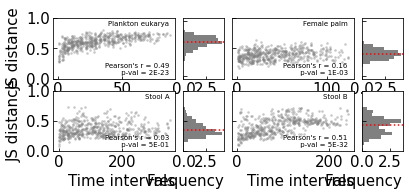

In [38]:

keys = ['plankton_eukarya', 'Caporaso_F4_L_palm_L6', 'David_stool_A', 'David_stool_B']
titles = ['Plankton eukarya', 'Female palm', 'Stool A', 'Stool B']

fig = plt.figure(figsize=(ELIFE.TEXTWIDTH, 2.5), tight_layout=True)
gs = gridspec.GridSpec(2,4, width_ratios=[3,1,3,1], hspace=0.2, wspace=0.1, 
                       top=0.92, bottom=0.18, left=0.1, right=0.98)

for i, key, title in zip(range(len(keys)), keys, titles):
    ax = fig.add_subplot(gs[2*i], sharey=ax if i>1 else None)
    axhist = fig.add_subplot(gs[2*i+1], sharey=ax if i>1 else None)
    
    ts = df_ts[key]; 
    ts = ts[[col for col in ts.columns if col.startswith('species')]].values
    
    c = list(combinations(range(len(ts)),2))
    np.random.shuffle(c)

    N = 500
    JS = np.zeros(N)
    ti = np.zeros(N)
    
    for ii, comb in enumerate(c[:N]):
        JS[ii] = JensenShannon(ts[comb[0]] + 1e-10, ts[comb[1]] + 1e-10)
        ti[ii] = np.abs(comb[0] - comb[1]) # time interaval
    
    if sum(~np.isnan(JS)) > 2:
        corr, pval = pearsonr(JS[(~np.isnan(JS))&(ti>14)], ti[(~np.isnan(JS))&(ti>14)])
    else:
        corr, pval = np.nan, np.nan
    
    ax.text(0.95, 0.95, title, 
                ha='right', va='top', fontsize=ELIFE.FONTSIZE, transform = ax.transAxes)
    ax.text(0.95, 0.05, "Pearson's r = %.2f\n p-val = %.0E" % (corr, pval), 
                ha='right', va='bottom', fontsize=ELIFE.FONTSIZE, transform = ax.transAxes)
    if i >= 2:
        ax.set_xlabel('Time intervals', x=1, ha='right')
        axhist.set_xlabel("Frequency", x=1, ha='right')
    
    ax.scatter(ti, JS, s=3, color='grey', alpha=0.3)
    ax.set_ylim([0,1])
    axhist.hist(JS, bins=np.linspace(0,1,20), density=True, orientation='horizontal', color='grey')
    axhist.axhline(y=np.median(JS), label='median', color='red', linestyle=':')
    
    if i % 2 == 0:
        ax.set_ylabel('JS distance')
    else:
        ax.tick_params(labelleft=False)
    #if i == len(keys)-1:
    #    axhist.legend()
    axhist.tick_params(labelleft=False)

#plt.savefig('figures/experimental_JS.pdf')
plt.show()

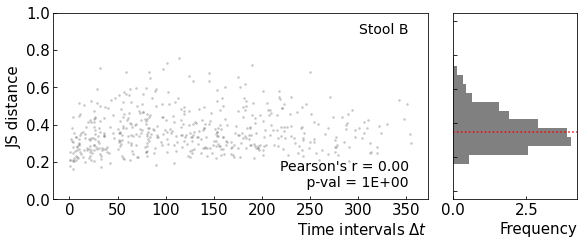

In [39]:


key = ['David_stool_A']
titles = ['Stool A']

fig = plt.figure(figsize=(1.5*ELIFE.TEXTWIDTH,3.5), tight_layout=True)
gs = gridspec.GridSpec(1,2, width_ratios=[3,1], hspace=0.2, wspace=0.1, 
                       top=0.92, bottom=0.18, left=0.1, right=0.98)
i=1
ax = fig.add_subplot(gs[0], sharey=ax if i>1 else None)
axhist = fig.add_subplot(gs[1], sharey=ax if i>1 else None)

ts = df_ts['David_stool_A']; 
ts = ts[[col for col in ts.columns if col.startswith('species')]].values

c = list(combinations(range(len(ts)),2))
np.random.shuffle(c)

N = 500
JS = np.zeros(N)
ti = np.zeros(N)

for ii, comb in enumerate(c[:N]):
    JS[ii] = JensenShannon(ts[comb[0]] + 1e-10, ts[comb[1]] + 1e-10)
    ti[ii] = np.abs(comb[0] - comb[1]) # time interaval

if sum(~np.isnan(JS)) > 2:
    corr, pval = pearsonr(JS[(~np.isnan(JS))&(ti>14)], ti[(~np.isnan(JS))&(ti>14)])
else:
    corr, pval = np.nan, np.nan

ax.text(0.95, 0.95, title, 
            ha='right', va='top', fontsize=14, transform = ax.transAxes)
ax.text(0.95, 0.05, "Pearson's r = %.2f\n p-val = %.0E" % (corr, pval), 
            ha='right', va='bottom', fontsize=14, transform = ax.transAxes)
ax.set_xlabel('Time intervals $\Delta t$', x=1, ha='right')
axhist.set_xlabel("Frequency", x=1, ha='right')

ax.scatter(ti, JS, s=3, color='grey', alpha=0.3)
ax.set_ylim([0,1])
axhist.hist(JS, bins=np.linspace(0,1,20), density=True, orientation='horizontal', color='grey')
axhist.axhline(y=np.median(JS), label='median', color='red', linestyle=':')

ax.set_ylabel('JS distance')

#ax.tick_params(labelleft=False)
#if i == len(keys)-1:
#    axhist.legend()
axhist.tick_params(labelleft=False)
if savefigures:
    plt.savefig('experimental_JS.pdf')
plt.show()

and the median Jensen Shannon distance between bacterial composition of the stool of different individuals ranges from 0.4 to 0.5.

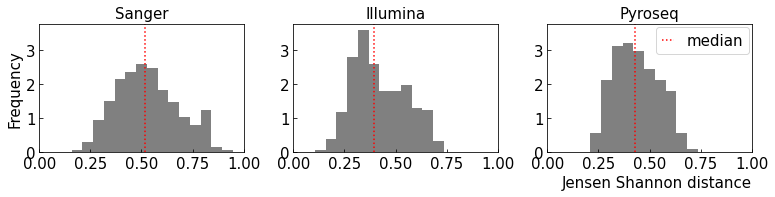

In [42]:
fig = plt.figure(figsize=(ELIFE.TEXTWIDTH*2,1.5*2), tight_layout=True)

for i, key in enumerate(df_st.keys(), start=1):
    ax = fig.add_subplot(1, len(df_st.keys()), i, sharey=ax if i>1 else None)
    ax.set_title(key)

    df = df_st[key].copy()
    
    if '-1' in df.columns:
        df.drop('-1', axis=1, inplace=True)
    elif '1' in df.columns:
        df.drop('1', axis=1, inplace=True)
        
    c = list(combinations(df.index, 2))

    N = min(len(c), 1000)

    JS = np.zeros(N)

    for ii, comb in enumerate(c[:N]):
        JS[ii] = JensenShannon(df.loc[comb[0]] + 1e-10, df.loc[comb[1]] + 1e-10)

    ax.hist(JS, bins=np.linspace(0,1,20), density=True, color='grey')
    ax.set_xlim([0,1])
    ax.axvline(x=np.median(JS), label='median', color='red', linestyle=':')
    
    if i == len(df_st.keys()):
        ax.set_xlabel("Jensen Shannon distance", ha='right', x=1)
        ax.legend()
    if i == 1:
        ax.set_ylabel("Frequency")

#plt.savefig('figures/experimental_JS2.pdf')
plt.show()

$\newcommand{\Nmax}{N_\text{max}}$
$\newcommand{\Nspec}{N_\text{spec}}$

## Maximal capacity key for heavy-tailed distributions?

Solé reported that heavy-tailed distributions can be obtained through an individual based modeling approach with a fixed maximum number of species. stochastic cellular automaton, microbial communities (Coyte 2015).

Maximal capacity can be interpreted as limits by fundamental resources (water, sugars?, space)

We can add a maximal capacity to logistic and gLV models by multiplying all positive growth terms with a growth probability $\gamma$ that depends on the total number of individuals $\Nmax$, $\gamma = 1 - \sum_j x_j / \Nmax$. In gLV, the growth vector $g$ can be split into its positive and negative components $g = g^+ + g^-$. Species for which the growth term is positive can grow in the absence of other species, species with a strictly negative growth term will need to be positively influenced by other species to have a non-zero positive steady state abundance since the self-interaction is always negative. The interaction matrix can be split in an equivalent way into its positive and negative parts: $\omega = \omega^+ + \omega^-$. Only the positive growth terms are multiplied by the probability for growth that depends on the fraction of "empty space" that remains. Furthermore, we limit the probability for growth $\gamma$ such that it is a value between $0$ and $1$. This constraint is important, because we could imagine a steady state starting with more individuals than the maximal capacity. Without a limit at $0$ $\gamma$ could become negative and the growth term becomes a death term. For population based generalized Lotka-Volterra models, a maximal number of species can be implemented as follows:

\begin{align}
d x_i(t) = \left(\lambda_i + g_i^- x_i(t) + \sum_j \omega_{ij}^- x_i(t) x_j(t) + \gamma(t) \left( g_i^+ x_i(t) + \sum_j \omega_{ij}^+ x_i x_j\right)\right) dt \\
\gamma(t) = max(0, 1 - \frac{\sum_i x_i(t)}{N_\text{max}})
\end{align}

Higher order terms also in (Hoffman 2007).

# Analysis of synthetic time series: Figures 3, 4, 5 & 7 



Solé et al. (2002) obtains heavy-tailed distributions with an IBM. 

Do we obtain same results with our implementation of an IBM and with gLV?

<b> Sketch of the code </b>


The actual plotting are done via the following functions: 

The overview figure: 
- overview_figure
- overview_figure_complete
- overview_figure_slide 

For those overview figures, you <b> choose </b> (a) the model you want to run essentially IBM or gLV and (b) two parameter types (such as connectance, immigration rate, interaction strength...) which are the ones that will be varied and then you <b> specifify </b> the chosen values for the other parameters (which are fixed). The figure consists of an ensemble of plots representing specific characteristics of the abundance distributions, eg fit to lognormal/normal/power law, the width of the fitted lognormal distribution, the number of surviving species, the JS coefficient or the coef of variation as a function of the two chosen parameters. 

The code relies on loading the stored results (obtained on a cluster - see testing_can.ipynb) - saved data is loaded via the function read_df: 


For gLV timeseries:

* scan over 'noise' and 'max_cap': scan_glv_maxcap_immi.csv
* scan over 'interaction' and 'connectance': scan_glv_interactions_immi.csv
* scan over 'max_cap' and 'connectance': scan_glv_maxcap_immi.csv
* scan over 'immigration' and 'connectance': scan_glv_immigration_immi.csv
* scan over 'immigration' and 'connectance' with constant noise: scan_glv_immigration_immi_constant.csv'


For logistic timeseries:
* linear noise: scan_logistic_immi.csv'
* constant noise: scan_logistic_constant.csv'

For IBM timeseries:

* scan_ibm.csv

The figure obtained with figure_distribution_width represents the distribution of width. 


The figure obtained with figure_changing_maxcap studies the effects of changing the maximal capacity. 


All these function call "fill_axes" which calls "comparison_matrix" which calls "read_df" (importing the simulations). 


## Help functions

In [52]:


def example_timeseries(connectance, immigration, int_strength, noise=None, 
                       max_cap=None, sites=None, S=200, 
                       noise_implementation=NOISE.LANGEVIN_LINEAR):
    
    if sites == None:
        params = random_parameter_set(S, 
           minmigration=immigration, maxmigration=immigration, connectance=connectance,
           minint=-int_strength, maxint=int_strength)
        
        if np.isinf(max_cap):
            model = MODEL.GLV
            params['initial_condition'] = np.random.uniform(0, 1, [S,1])
        else:
            model = MODEL.MAX
            params['maximum_capacity'] = max_cap
            initcond = np.random.uniform(0, 1, [S,1])
            params['initial_condition'] = initcond*max_cap/S
        if noise_implementation == NOISE.LANGEVIN_LINEAR:
            params['noise_linear'] = noise
        elif noise_implementation == NOISE.LANGEVIN_SQRT:
            params['noise_sqrt'] = noise
        elif noise_implementation == NOISE.LANGEVIN_CONSTANT:
            params['noise_constant'] = noise
        
    elif sites != None and max_cap == None:
        params = random_parameter_set_ibm(S,
           minmigration=immigration, maxmigration=immigration, 
                                          connectance=connectance,
           minint=-int_strength, maxint=int_strength)
    
        model = MODEL.IBM
        params['initial_condition'] = np.random.randint(0, int(0.66*sites/S), S)
        params['sites'] = sites
    return show_example(params, model, noise_implementation)

def example_timeseries_logistic(width_growth, noise, S=200):
    params = random_parameter_set_logistic(S, width_growth)

    #interaction_SIS = add_SIS(interaction, SISvector)
    initcond = np.random.uniform(0, 1, [S,1])
    
    params = {'interaction_matrix' : interaction, 'immigration_rate' : immigration, 
            'extinction_rate' : extinction, 'initial_condition' : initcond, 
            'noise_linear' : noise, 'growth_rate' : growth_rate}
    
    return show_example(params, MODEL.GLV)

def show_example(params, model, noise_implementation):
    # find steady state without noise
    if model in [MODEL.GLV, MODEL.MAX]:
        params_init = params.copy()
        params_init['noise_linear'] = 0
        ts = glv.Timeseries(params_init, T = 125, dt=0.005, tskip=199, model=model)
        discrete = False
    elif model == MODEL.IBM:
        ts = ibm.Timeseries(params, T = 150)
        discrete = True
        
    stab = (np.max(np.abs((ts.timeseries.iloc[-50, 1:] - ts.timeseries.iloc[-1, 1:])/ ts.timeseries.iloc[-50, 1:])) < 0.1)
    print("Deterministic solution is stable:", stab)
    #if stab == False:
    #    print(ts.timeseries.iloc[0,:])
    #    print(ts.timeseries.iloc[1,:])
    ep = ts.endpoint
    col_to_drop = ep.index[ep.endpoint < 1e-6*np.max(ep.endpoint)]
    
    PlotTimeseries(ts.timeseries.drop(columns=col_to_drop))

    if model in [MODEL.GLV, MODEL.MAX]:
        params['initial_condition'] = ts.endpoint.values.astype('float')
        ts = glv.Timeseries(params, T = 250, dt=0.005, tskip=199, model=model, noise_implementation=noise_implementation)
    elif model == MODEL.IBM:
        params['initial_condition'] = ts.endpoint.values.astype('int').flatten()
        ts = ibm.Timeseries(params, T = 250)
    PlotTimeseries(ts.timeseries.drop(columns=col_to_drop))
    params = variation_coefficient(ts.timeseries)
    print("variation:", params[0])
    params = JS(ts.timeseries, verbose=True)
    print("JS:", params[0])
    print("pval stable (higher more stable):", params[-1])
    
    ep = ts.endpoint.values.astype('float').flatten()
    ep = ep[ep > 1e-6*np.max(ep)]
    
    print("remaining species", len(ep))
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    print("things", ep[0], ep[-1], len(ep), discrete)
    params = fit_heavytail(ep, func='lognorm', discrete=discrete)
    plot_heavytail(ep, params, func='lognorm', ax=ax, discrete=discrete)
    print("Width lognorm:", params[0], params[1], params[2])
    print("Stat lognorm:", params[-2])
    for f in ['expon', 'norm', 'powerlaw', 'pareto']:
        params = fit_heavytail(ep, func=f, discrete=discrete)
        plot_heavytail(ep, params, func=f, ax=ax, discrete=discrete)
        print("Stat %s:" % f, params[-2])
    params = fit_heavytail(ep, func='trunc_powerlaw', discrete=discrete)
    plot_heavytail(ep, params, func='trunc_powerlaw', ax=ax, discrete=discrete)
    print("Stat trunc powerlaw:", params[-2])
    print("R powerlaw (negative -> lognormal):", params[2])
    
    return ep

In [57]:

default = {'glv': {'connectance': 0.3162,
                   'immigration': 0.1, 'noise': 0.3162, 'interaction': 0.3162, 'max_cap': 1e2},
           'glv_sqrt': {'connectance': 0.3162, 'immigration': 0.1, 'noise': 0.1, 'interaction': 0.3162},
           'ibm': {'connectance': 0.1, 'immigration': 0.01, 'sites': 10000, 'interaction': 0.1}}
columns = {'glv': ['connectance', 'immigration', 'noise', 'interaction', 'max_cap'],
           'glv_sqrt': ['connectance', 'immigration', 'noise', 'interaction'],
           'ibm': ['connectance', 'immigration', 'sites', 'interaction'],
           'logistic': ['width_growth', 'noise']}
labels = {'connectance': 'Connectance', 'immigration': 'Immigration',
          'interaction': 'Interaction strength', 'noise': 'Noise strength',
          'sites': 'Maximum number\n of individuals', 'max_cap': 'Maximal capacity',
          'JS_mean': 'Average JS distance',
          'variation_mean': 'Average coefficient\n of variation',
          'variationnorm_mean': 'Average coefficient\n of variation',
          'width': 'Width of lognormal\n distribution',
          'JS_stab': 'p-value time dependence\n JS distance',
          'width_growth': 'Width of the growth rates',
          'number': 'Number of species', }


def select_rows(df, x, y, params, verbose=False):
    if verbose:
        print("len df:", len(df))
    if params == None:
        params = default[model]

    df_selection = df.copy()
    for v in params:
        if x != v and y != v:
            df_selection = df_selection[df_selection[v] == params[v]]
        if verbose:
            print(v, len(df_selection))
    return df_selection


def select_columns(all_cols, model, dist, var):
    if dist == 'all':
        cols = columns[model] + \
            [col for col in all_cols if ('_pval_' in col) or ('_R_' in col)]
    elif dist == None:
        cols = columns[model] + \
            ['%s_%d' % (var, d) for d in range(1, 11)]
    else:
        cols = columns[model] + \
            ['%s_%s_%d' % (dist, var, d) for d in range(1, 11)]
        if var == 'width':
            cols += [col for col in all_cols if ('_pval_' in col)
                     or ('_R_' in col)]
    return cols


def read_df(x, y, var, dist, model, params, noise_implementation, verbose=False):
    if model == 'glv':
        if 'noise' in [x, y] and 'max_cap' in [x, y]:
            filename = 'results/scan_glv_maxcap_immi.csv'
        elif 'interaction' in [x, y] and 'connectance' in [x, y]:
            filename = 'results/scan_glv_interactions_immi.csv'
        elif 'max_cap' in [x, y] and 'connectance' in [x, y]:
            filename = 'results/scan_glv_maxcap_immi.csv'
        elif 'immigration' in [x, y] and 'connectance' in [x, y]:
            filename = 'results/scan_glv_immigration_immi.csv'
        else:
            pass

        if noise_implementation == NOISE.LANGEVIN_LINEAR:
            pass
        elif noise_implementation == NOISE.LANGEVIN_CONSTANT:
            filename = filename[:-4] + '_constant.csv'
        else:
            print('Noise implementation does not exist!')

        headers = pd.read_csv(filename, index_col=None, #to do I think I can remove this same (same code just below)
                              header=0, dtype=float, na_values='NAN', nrows=0)#to do I think I can remove this same (same code just below)
        cols = select_columns(headers.columns, model, dist, var)#to do I think I can remove this same (same code just below)
        df = pd.read_csv(filename, index_col=None, header=0,#to do I think I can remove this same (same code just below)
                         dtype=float, na_values='NAN', usecols=cols)#to do I think I can remove this same (same code just below)
        
        if False: #11
            if 'interaction' in [x, y] and 'connectance' in [x, y] and noise_implementation == NOISE.LANGEVIN_LINEAR:
                df = df[np.isfinite(df.max_cap)]
                df = pd.concat([df, pd.read_csv('results/scan_glv_interactions_inf.csv',
                                                index_col=None, header=0,
                                                dtype=float, na_values='NAN', usecols=cols)])
            elif 'immigration' in [x, y] and 'connectance' in [x, y] and noise_implementation == NOISE.LANGEVIN_LINEAR:
                df = df[np.isfinite(df.max_cap)]
                df = pd.concat([df, pd.read_csv('results/scan_glv_immigration_inf.csv',
                                                index_col=None, header=0,
                                                dtype=float, na_values='NAN', usecols=cols)])

        df = select_rows(df, x, y, params, verbose)
        return df
    elif model == 'logistic':
        if noise_implementation == NOISE.LANGEVIN_LINEAR:
            filename = 'results/scan_logistic_immi.csv'
        elif noise_implementation == NOISE.LANGEVIN_CONSTANT:
            filename = 'results/scan_logistic_constant.csv'
    elif model == 'ibm':
        filename = 'results/scan_ibm.csv'  # ibm_total.csv'

    headers = pd.read_csv(filename, index_col=None, header=0,
                          dtype=float, na_values='NAN', nrows=0)
    cols = select_columns(headers.columns, model, dist, var)
    df = pd.read_csv(filename, index_col=None, header=0,
                     dtype=float, na_values='NAN', usecols=cols)
    df = select_rows(df, x, y, params, verbose)

    return df


def add_distribution_percentages(df):
    df['pow_perc'], df['log_perc'], df['norm_perc'], \
        df['pareto_perc'], df['tpow_perc'], \
        df['pows_perc'], df['linear_dist'], df['undefined_perc'] \
        = np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

    def perc(row):
        if True:
            powrow = row[['pow_pval_%d' % d for d in range(1, 11)]].values 
            tpowrow = row[['tpow_pval_%d' % d for d in range(1, 11)]].values
            parrow = row[['pareto_pval_%d' % d for d in range(1, 11)]].values
            logrow = row[['log_pval_%d' % d for d in range(1, 11)]].values
            normrow = row[['norm_pval_%d' % d for d in range(1, 11)]].values

            row['pareto_perc'] = np.sum((parrow > normrow) & (parrow > logrow) &
                                        (parrow > powrow) & (parrow > tpowrow)
                                        & (parrow > 0.05))/len(parrow)
            row['pow_perc'] = np.sum((powrow > normrow) & (powrow > logrow) &
                                     (powrow > parrow) & (powrow > tpowrow)
                                     & (powrow > 0.05))/len(powrow)
            row['log_perc'] = np.sum((logrow > normrow) & (logrow > parrow) &
                                     (logrow > powrow) & (logrow > tpowrow)
                                     & (logrow > 0.05))/len(logrow)
            row['norm_perc'] = np.sum((normrow > logrow) & (normrow > parrow) &
                                      (normrow > powrow) & (normrow > tpowrow)
                                      & (normrow > 0.05))/len(normrow)
            row['tpow_perc'] = np.sum((tpowrow > normrow) & (tpowrow > logrow) &
                                      (tpowrow > parrow) & (tpowrow > powrow)
                                      & (tpowrow > 0.05))/len(tpowrow)
            row['pows_perc'] = row['pareto_perc'] + \
                row['pow_perc'] + row['tpow_perc']
            row['undefined_perc'] = np.sum((normrow < 0.05) & (logrow < 0.05) &
                                           (powrow < 0.05) & (tpowrow < 0.05) & (parrow < 0.05))

            # if row['norm_perc'] != 0 and row['log_perc'] != 0 and row['pows_perc'] != 0:
            #    print('cannot convert to linear scale (norm, log, pows)', row['norm_perc'], row['log_perc'], row['pows_perc'])

            row['linear_dist'] = 0.5 * \
                (1 - row['norm_perc']) + 0.5*row['pows_perc']
        elif np.any(['_R_' in col for col in df.columns]):
            powrow = row[['tpow_R_%d' % d for d in range(1, 11)]].values 
            logrow = row[['log_pval_%d' % d for d in range(1, 11)]].values 
            normrow = row[['norm_pval_%d' % d for d in range(1, 11)]].values 

            row['pows_perc'] = np.sum(powrow > 0)/len(powrow)
            row['log_perc'] = np.sum((logrow > normrow) & (
                powrow < 0) & (logrow > 0.05))/len(logrow)
            row['norm_perc'] = np.sum((normrow > logrow) & (
                powrow < 0) & (normrow > 0.05))/len(normrow)
            row['pareto_perc'] = 0
            row['tpow_perc'] = 0
            row['undefined_perc'] = 0
        else:
            powrow = row[['pow_pval_%d' % d for d in range(1, 11)]].values 
            logrow = row[['log_pval_%d' % d for d in range(1, 11)]].values 
            normrow = row[['norm_pval_%d' % d for d in range(1, 11)]].values 

            row['pow_perc'] = np.sum((powrow > normrow) & (
                powrow > logrow) & (powrow > 0.05))/len(powrow)
            row['log_perc'] = np.sum((logrow > normrow) & (
                logrow > powrow) & (logrow > 0.05))/len(logrow)
            row['norm_perc'] = np.sum((normrow > logrow) & (
                normrow > powrow) & (normrow > 0.05))/len(normrow)
        return row

    df = df.apply(perc, axis=1)

In [58]:
def comparison_matrix(x='connectance', y='immigration', var='pval', dist='log', 
                      agg='median', ax=None, ax_cbar=None, model='glv', params=None, 
                      noise_implementation=NOISE.LANGEVIN_LINEAR, verbose=False):
    df = read_df(x, y, var, dist, model, params, noise_implementation, verbose)
    
    if ax == None:
        fig = plt.figure()
        gs = gridspec.GridSpec(1,2,width_ratios=[3,1] if dist == 'all' else [15,1])
        ax = fig.add_subplot(gs[0])
        ax_cbar = fig.add_subplot(gs[1], aspect='equal' if dist == 'all' else 'auto')
    
    norm = normalizations[var]
    if norm == None:
        norm = lambda x : x
    cmap = plt.cm.seismic
    
    # set background to grey
    ax.set_facecolor((0.8, 0.8, 0.8))
    
    if dist == 'all':
        add_distribution_percentages(df)
        
        #print("pareto", np.sum(df.pareto_perc), "powerlaw", np.sum(df.pow_perc), 
        #      "truncated powerlaw", np.sum(df.tpow_perc), "norm", np.sum(df.norm_perc), 
        #      "log", np.sum(df.log_perc), "undefined", np.sum(df.undefined_perc))
        
        df['dist_color'] = df.apply(lambda row: abc_to_rgba(
            row['log_perc'], row['pows_perc'], row['norm_perc']), axis=1)
        
        mat = df.pivot_table(values='dist_color', index=y, columns=x, dropna=False, aggfunc='first')
        # no aggregation
        assert np.product(mat.shape) == df.shape[0]
        
        im = ax.imshow( np.array([[np.array(i, dtype=float) for i in j] for j in mat.to_numpy()],
        dtype=float,), aspect='auto', origin='lower')
    else:
        df['agg'] = df[[('%s_%s_%d' % (dist, var, d) if dist != None
                         else '%s_%d' % (var,d))
                         for d in range(1,11)]].agg(agg, axis="columns").astype(float) 
        df['nonan'] = 1. - 1./10.* df[[('%s_%s_%d' % (dist, var, d) if dist != None 
                         else '%s_%d' % (var,d))
                         for d in range(1,11)]].isna().sum(axis="columns") 
        
        mat = df.pivot_table(values='agg', index=y, columns=x, dropna=False)

        if var == 'width':
            add_distribution_percentages(df)
            mat_alpha = df.pivot_table(values='log_perc', index=y, columns=x, dropna=False)
        else:
            mat_alpha = df.pivot_table(values='nonan', index=y, columns=x, dropna=False)
            #np.ones_like(mat)
            
        # no aggregation
        #assert np.product(mat.shape) == df.shape[0]
        #assert mat.shape == mat_alpha.shape
        
        colors = cmap(norm(mat.to_numpy()))
        colors[:,:,-1] = mat_alpha
        
        im = ax.imshow(colors, aspect='auto', origin='lower')
            
    ax.set_xticks(range(0, len(mat.columns), 1))
    ax.set_yticks(range(0, len(mat.index), 1))
    
    xlabels = ['INF' if np.isinf(i) else '%d' % i if int(i) == i else '%.1f' % i 
               if round(i, 1) == i else '%.2f' % i 
               if round(i, 2) == i else '%.2E' % i for i in mat.columns]
    ylabels = ['INF' if np.isinf(i) else '%d' % i if int(i) == i else '%.1f' % i 
               if round(i, 1) == i else '%.2f' % i 
               if round(i, 2) == i else '%.2E' % i for i in mat.index]
    
    ax.set_xticklabels(xlabels, rotation=90)
    ax.set_yticklabels(ylabels)
    ax.set_xlabel(labels[x], ha='right', x=1)
    ax.set_ylabel(labels[y])
    
    if not ax_cbar == None:
        if dist == 'all':
            plot_legend(ax_cbar, labels=['lognormal', 'power\n law', 'normal'], 
                        fontsize=12) #PRESENTATION.FONTSIZE)
        else:
            #plt.colorbar(im, cax=ax_cbar, label=labels[var])
            mcolorbar.ColorbarBase(ax_cbar, orientation='vertical', 
                               cmap=cmap, norm=norm, label=labels[var], 
                                   ticks=[0,50,100,150,200] if var=='number' else None)
    return mat

In [65]:
def fill_axes(axes, cbar, variables, distributions, model, Nrows, Ncolumns,
              xticklabels='auto', yticklabels='auto',
              noise_implementation=NOISE.LANGEVIN_LINEAR, add_label=True):
    for i, label in zip(count(), axes.keys()):
        if axes[label] == None:
            continue
            
        if add_label:
            axes[label].text(-0.3 if i % Ncolumns == 0 else -0.15, 1.02, label, transform = axes[label].transAxes, size=9)
        mat = comparison_matrix(x=x, y=y, var=variables[label], dist=distributions[label], model=model,
                            agg=np.nanmedian, ax=axes[label], ax_cbar=cbar[label], params=params, 
                            noise_implementation=noise_implementation)
        
        if distributions[label] == 'all' and cbar[label] != None:
            a, b = cbar[label].get_xlim(); w = b - a
            cbar[label].set_xlim(a - 0.4*w, b + 0.6*w)
        
        if i < len(axes) - 1:
            axes[label].set_xlabel('')
        axes[label].set_ylabel('')
        
        if i % Ncolumns == 0 and yticklabels != None:
            if yticklabels == 'auto':
                pass
            else:
                axes[label].set_yticklabels(yticklabels, rotation=0)
        else:
            axes[label].set_yticklabels([])
        
        if i >= (Nrows - 1)*Ncolumns and xticklabels != None: # and add_label:
            if xticklabels == 'auto':
                pass
            else:
                axes[label].set_xticklabels(xticklabels, rotation=0)
        else:
            axes[label].set_xticklabels([])

def overview_figure(model, x, y, params, xticklabels='auto', yticklabels='auto', 
                    noise_implementation=NOISE.LANGEVIN_LINEAR):
    scale=2
    fig = plt.figure(figsize=(ELIFE.TEXTWIDTH*scale, 3*scale), tight_layout=True)
    
    gs = gridspec.GridSpec(2,5,width_ratios=[10,1,5,10,1],wspace=0.1,hspace=0.1,top=0.9,
                           bottom=0.15, right=0.88)
    gst = gridspec.GridSpec(1,1,top=0.9,bottom=0.15, left=0.05, right=0.88)
    
    axes = {'A' : fig.add_subplot(gs[0,0]), 'B' : fig.add_subplot(gs[0,3]), 
            'C' : fig.add_subplot(gs[1,0]), 'D' : fig.add_subplot(gs[1,3]), }
    cbar = {'A' : fig.add_subplot(gs[0,1]), 'B' : fig.add_subplot(gs[0,4]), 
            'C' : fig.add_subplot(gs[1,1]), 'D' : fig.add_subplot(gs[1,4]), }
    variables = {'A' : 'width', 'B' : 'number', 'C' : 'variationnorm_mean', 'D' : 'JS_mean'}
    distributions = {'A' : 'log', 'B' : None, 'C' : None, 'D' : None}

    
    fill_axes(axes, cbar, variables, distributions, model, 2, 2, xticklabels, yticklabels, 
                    noise_implementation)  
    
    ax = fig.add_subplot(gst[:], frameon=False)
    ax.set_ylabel(labels[y])
    ax.set_yticks([])
    ax.set_xticks([])
    
    fig.align_labels()
    return fig

def overview_figure_slide(model, x, y, params, xticklabels='auto', yticklabels='auto', 
                    noise_implementation=NOISE.LANGEVIN_LINEAR):
    fig = plt.figure(figsize=(0.9*PRESENTATION.SLIDEWIDTH, 0.4*PRESENTATION.SLIDEHEIGHT), tight_layout=True)
    
    gs = gridspec.GridSpec(1,7,width_ratios=[10,5,10,1,6,10,1],wspace=0.1,hspace=0.1,top=0.9,
                           bottom=0.15, right=0.88)
    gst = gridspec.GridSpec(1,1,top=0.9,bottom=0.15, left=0.05, right=0.88)
    
    axes = {'A' : fig.add_subplot(gs[0]), 'B' : fig.add_subplot(gs[2]), 
            'C' : fig.add_subplot(gs[5])}
    cbar = {'A' : fig.add_subplot(gs[1], aspect='equal'), 'B' : fig.add_subplot(gs[3]), 
            'C' : fig.add_subplot(gs[6])}
    variables = {'A' : None, 'B' : 'width', 'C' : 'number'}
    distributions = {'A' : 'all', 'B' : 'log', 'C' : None}

    fill_axes(axes, cbar, variables, distributions, model, 1, 3, xticklabels, yticklabels, 
                    noise_implementation, add_label=False)
    
    ax = fig.add_subplot(gst[:], frameon=False)
    ax.set_ylabel(labels[y])
    ax.set_yticks([])
    ax.set_xticks([])
    
    fig.align_labels()
    return fig

def figure_distribution_width(model, x, y, params, xticklabels='auto', yticklabels='auto', 
                    noise_implementation=NOISE.LANGEVIN_LINEAR):
    scale = 2 
    fig = plt.figure(figsize=(ELIFE.TEXTWIDTH*scale, 1.5*scale), tight_layout=True)
    
    gs = gridspec.GridSpec(1,5,width_ratios=[10,1,5,10,1],wspace=0.1,hspace=0.1,top=0.9,
                           bottom=0.2, right=0.88)
    gst = gridspec.GridSpec(1,1,top=0.9,bottom=0.15, left=0.05, right=0.88)
    
    axes = {'A' : fig.add_subplot(gs[0,0]), 'B' : fig.add_subplot(gs[0,3])}
    cbar = {'A' : fig.add_subplot(gs[0,1:3], aspect='equal'), 'B' : fig.add_subplot(gs[0,4])}
    variables = {'A' : None, 'B' : 'width'}
    distributions = {'A' : 'all', 'B' : 'log'}
    
    fill_axes(axes, cbar, variables, distributions, model, 1, 2, xticklabels, yticklabels, 
                    noise_implementation)
    
    ax = fig.add_subplot(gst[:], frameon=False)
    label = labels[y]
    if len(label) > 20:
        label_s = label.split(" ")
        label = " ".join(label_s[:int(len(label_s)/2)]) + "\n" + " ".join(label_s[int(len(label_s)/2):])
    ax.set_ylabel(label)
    ax.set_yticks([])
    ax.set_xticks([])

    return fig

def overview_figure_complete(model, x, y, params, xticklabels='auto', yticklabels='auto', 
                    noise_implementation=NOISE.LANGEVIN_LINEAR):
    scale=2
    fig = plt.figure(figsize=(ELIFE.TEXTWIDTH*scale, 4*scale), tight_layout=False)
    
    gs = gridspec.GridSpec(3,5,width_ratios=[10,1,5,10,1],wspace=0.1,hspace=0.1,top=0.95, #todo i changed: width_ratios=[10,5,10,1,10,1]
                           bottom=0.1, right=0.88)
    gst = gridspec.GridSpec(1,1,top=0.95,bottom=0.1, left=0.05, right=0.88)
    
    axes = {'A' : fig.add_subplot(gs[0,0]), 'B' : fig.add_subplot(gs[0,3]),
            'C' : fig.add_subplot(gs[1,0]), 'CC' : None,
            'D' : fig.add_subplot(gs[2,0]), 'E' : fig.add_subplot(gs[2,3]), 
           }
    cbar = {'A' : fig.add_subplot(gs[0,1:3], aspect='equal'), 'B' : fig.add_subplot(gs[0,4]),
            'C' : fig.add_subplot(gs[1,1]), 'CC' : None,
            'D' : fig.add_subplot(gs[2,1]), 'E' : fig.add_subplot(gs[2,4])}
    variables = {'A' : None, 'B' : 'width', 
                'C' : 'number', 
                 'D' : 'variationnorm_mean', 'E' : 'JS_mean'}
    distributions = {'A' : 'all', 'B' : 'log',
                     'C' : None, 
                     'D' : None, 'E' : None}
    
    fill_axes(axes, cbar, variables, distributions, model, 3, 2, xticklabels, yticklabels, 
                    noise_implementation)
    
    ax = fig.add_subplot(gst[:], frameon=False)
    ax.set_ylabel(labels[y])
    ax.set_yticks([])
    ax.set_xticks([])
    
    fig.align_labels()
    return fig

def figure_changing_maxcap(model, x, y, params, xticklabels='auto', yticklabels='auto',  
                    noise_implementation=NOISE.LANGEVIN_LINEAR):
    scale=3.5
    fig = plt.figure(figsize=(ELIFE.TEXTWIDTH*scale, 4*scale), tight_layout=True)

    gs = gridspec.GridSpec(3,6,width_ratios=[5,5,5,5,1,2.5],wspace=0.1,
                           top=0.9,bottom=0.1, right=0.95, left=0.07)

    max_caps = [np.inf, 1000, 200, 100]
    for i, max_cap in enumerate(max_caps):
        params['max_cap'] = max_cap
        
        axes = {'A' : fig.add_subplot(gs[0,i]), 
                'B' : fig.add_subplot(gs[1,i]), 
                'C' : fig.add_subplot(gs[2,i])}
        cbar = {'A' : fig.add_subplot(gs[0,-2]) if max_cap == max_caps[-1] else None,
                'B' : fig.add_subplot(gs[1,-2:], aspect='equal') if max_cap == max_caps[-1] else None,
                'C' : fig.add_subplot(gs[2,-2]) if max_cap == max_caps[-1] else None}
        
        axes['A'].set_title('$N_\mathrm{max} = \infty$' if np.isinf(max_cap) 
                            else '$N_\mathrm{max} =$' + ' %d' % int(max_cap))
        
        variables = {'A' : 'number', 'B' : None, 'C' : 'width'}
        distributions = {'A' : None, 'B' : 'all', 'C' : 'log'}
        
        fill_axes(axes, cbar, variables, distributions, model, 3, 1, xticklabels, yticklabels, 
                    noise_implementation, add_label= (i==0))
        
        if xticklabels == None:
            xticklabels = [x if i %2 == 0 else '' for i, x in enumerate(axes['C'].get_xticklabels())]
        
        if max_cap != max_caps[-1]:
            axes['C'].set_xlabel('')
            
    fig.align_ylabels()
    return fig

## Figure 3 : IBM 

In [60]:

#set_presentation_settings()

findfont: Font family ['Open Sans'] not found. Falling back to DejaVu Sans.


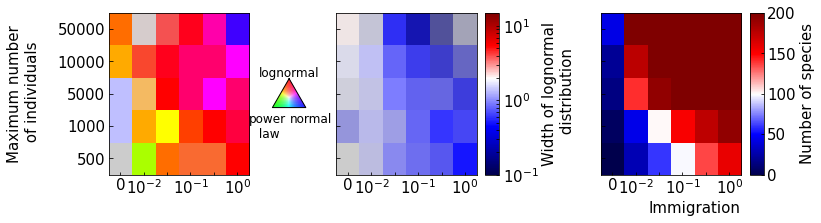

In [61]:

#extra figure
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model = 'ibm'
    x = 'immigration'; y = 'sites';
    params = {'interaction' : 0.75, 'connectance' : 0.5} # 'sites' : 5000

    xticklabels = ['0', '$10^{-2}$', '', '$10^{-1}$', '', '$10^{0}$']

    #overview_figure(model, x, y, params, xticklabels)
    #plt.savefig('figures/immigration_sites_ibm.pdf')
    #figure_distribution_width(model, x, y, params, xticklabels)
    #plt.savefig('figures/immigration_sites_ibm_dist.pdf')
        
    overview_figure_slide(model, x, y, params, xticklabels)
    #plt.savefig('../figures_presentation/ibm_dist.pdf')
    
    plt.show()

findfont: Font family ['Open Sans'] not found. Falling back to DejaVu Sans.


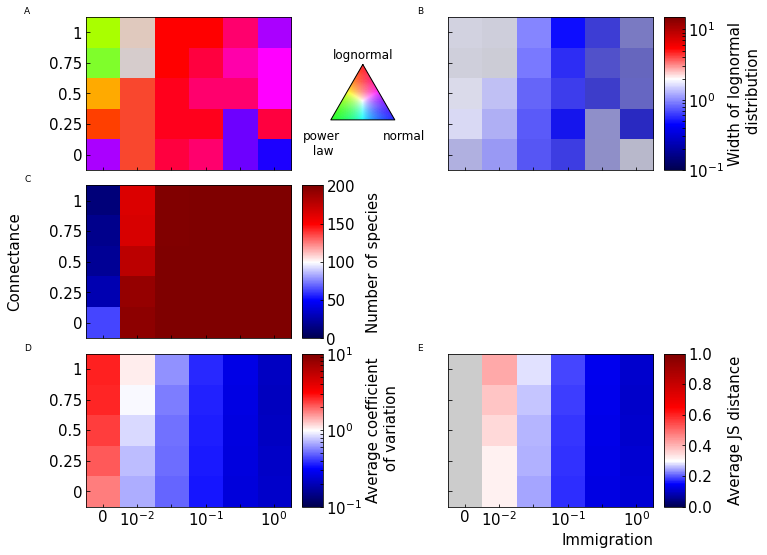

In [62]:
#figure 3
#fig = plt.figure(figsize=(ELIFE.TEXTWIDTH, 4), tight_layout=False)
set_presentation_settings()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model = 'ibm'
    x = 'immigration'; y = 'connectance';
    params = {'interaction' : 0.75, 'sites' : 10000} #

    xticklabels = ['0', '$10^{-2}$', '', '$10^{-1}$', '', '$10^{0}$']

    #overview_figure(model, x, y, params, xticklabels)
    #plt.savefig('figures/immigration_connectance_ibm.pdf')
    #overview_figure2(model, x, y, params, xticklabels)
    #plt.savefig('figures/immigration_connectance_ibm_dist.pdf')
    overview_figure_complete(model, x, y, params, xticklabels)
    #plt.savefig('figures/immigration_connectance_ibm_tot.pdf')
    
    #overview_figure_slide(model, x, y, params, xticklabels)
    #plt.savefig('../figures_presentation/ibm_dist.pdf')
    
    plt.show()

## Figure 4-5 : GLV 

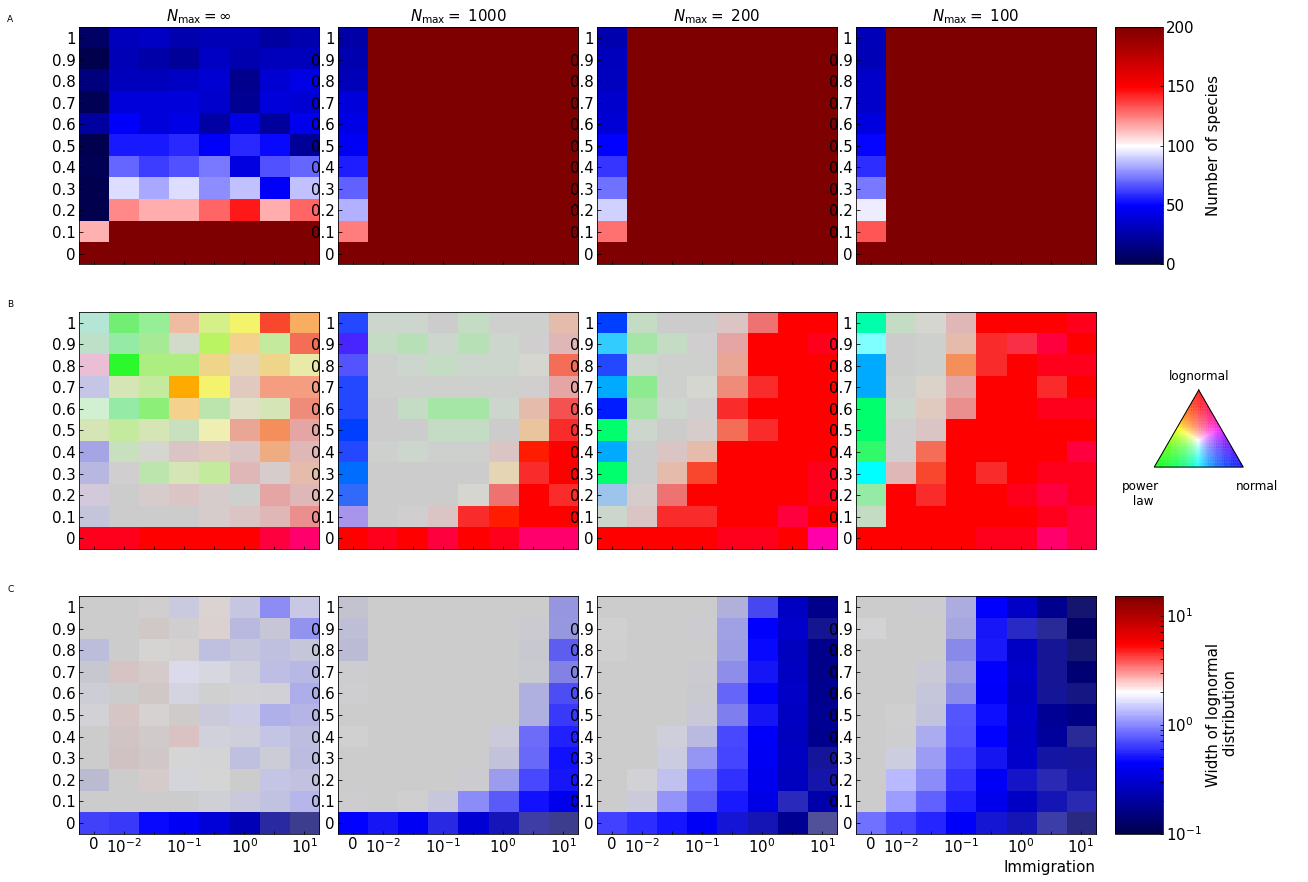

In [63]:
#figure 4
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    model = 'glv'
    x = 'immigration'; y = 'connectance';
    params = {'noise' : 0.5, 'interaction' : 0.5}
    
    xticklabels = ['0', '$10^{-2}$', '', '$10^{-1}$', '', '$10^{0}$', '', '$10^{1}$']
    
    figure_changing_maxcap(model, x, y, params, xticklabels=xticklabels, yticklabels='auto', 
                        noise_implementation=NOISE.LANGEVIN_LINEAR)
    #plt.savefig('figures/changing_maxcap2.pdf')
    
    #figure_changing_maxcap(model, x, y, params, xticklabels=xticklabels, yticklabels='auto', 
    #                    noise_implementation=NOISE.LANGEVIN_CONSTANT)
    plt.show()

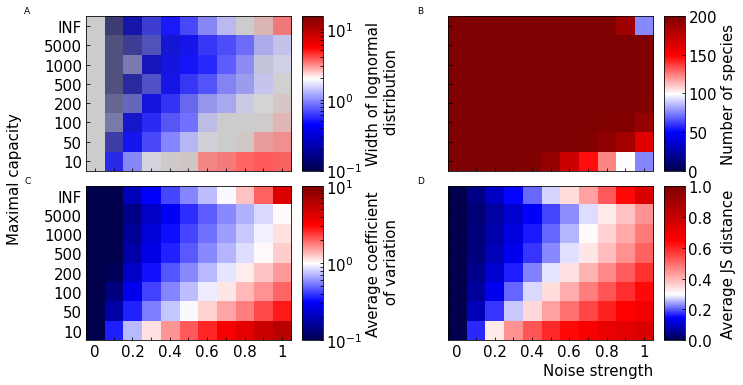

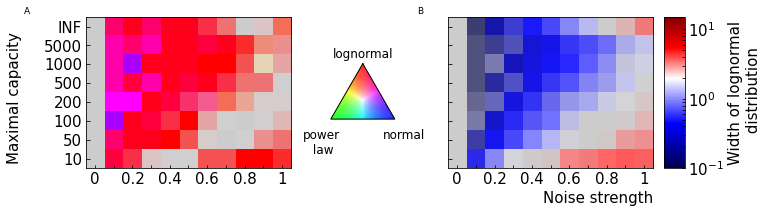

In [66]:
# figure 5 (with an extra line)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model = 'glv'
    x = 'noise'; y = 'max_cap';
    params = {'interaction' : 0., 'immigration' : 0., 'connectance' : 0.} #

    xticklabels = ['0', '', '0.2', '', '0.4','', '0.6', 
                   '', '0.8', '', '1']

    overview_figure(model, x, y, params, xticklabels)
    #plt.savefig('figures/maxcap_noise.pdf')
    figure_distribution_width(model, x, y, params, xticklabels)
    #plt.savefig('figures/maxcap_noise_dist.pdf')
    
    #overview_figure(model, x, y, params, noise_implementation=NOISE.LANGEVIN_CONSTANT)
    #overview_figure2(model, x, y, params, noise_implementation=NOISE.LANGEVIN_CONSTANT)
    
    plt.show()

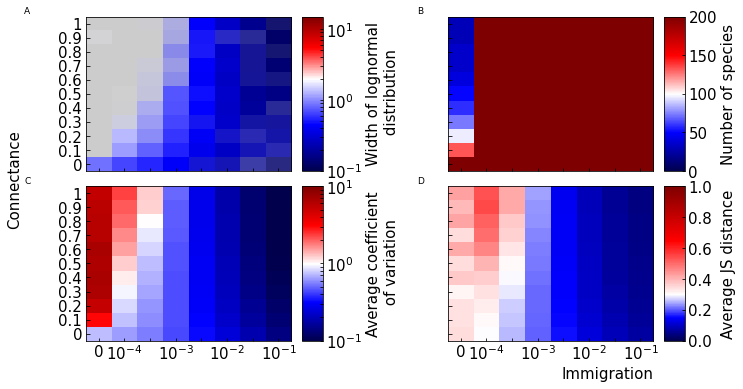

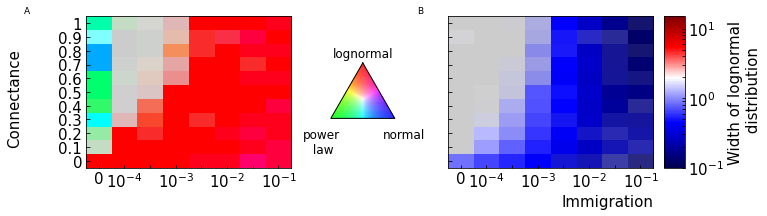

In [67]:
#extra figure

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model = 'glv'
    x = 'immigration'; y = 'connectance';
    params = {'noise' : 0.5, 'interaction' : 0.5, 'max_cap' : 100} #

    xticklabels = ['0', '$10^{-4}$', '', '$10^{-3}$', '','$10^{-2}$', '', 
                   '$10^{-1}$', '', '$10^{0}$', '', '$10^{1}$']

    overview_figure(model, x, y, params, xticklabels)
    #plt.savefig('figures/connectance_immigration_glv.pdf')
    figure_distribution_width(model, x, y, params, xticklabels)
    #plt.savefig('figures/connectance_immigration_glv_dist.pdf')
    
    #params = {'noise' : 1e-7, 'interaction' : 0.5, 'max_cap' : 100} #
    #overview_figure(model, x, y, params, xticklabels, noise_implementation=NOISE.LANGEVIN_CONSTANT)
    #overview_figure2(model, x, y, params, xticklabels, noise_implementation=NOISE.LANGEVIN_CONSTANT)
    
    plt.show()

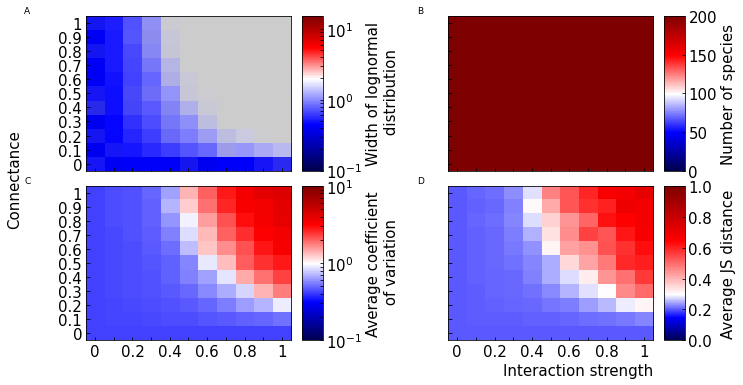

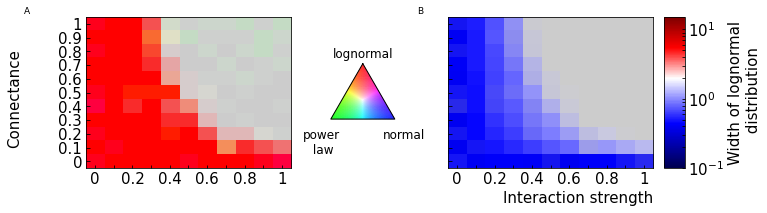

In [68]:
#extra figure

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model = 'glv'
    x = 'interaction'; y = 'connectance';
    params = {'noise' : 0.5, 'immigration' : 0.1, 'max_cap' : 200} #

    xticklabels = ['0', '', '0.2', '', '0.4','', '0.6', 
                   '', '0.8', '', '1']

    overview_figure(model, x, y, params, xticklabels)
    #plt.savefig('figures/interactions_glv_100.pdf')
    figure_distribution_width(model, x, y, params, xticklabels)
    #plt.savefig('figures/interactions_glv_100_dist.pdf')
    
    #overview_figure(model, x, y, params, xticklabels, noise_implementation=NOISE.LANGEVIN_CONSTANT)
    #overview_figure2(model, x, y, params, xticklabels, noise_implementation=NOISE.LANGEVIN_CONSTANT)
    
    plt.show()

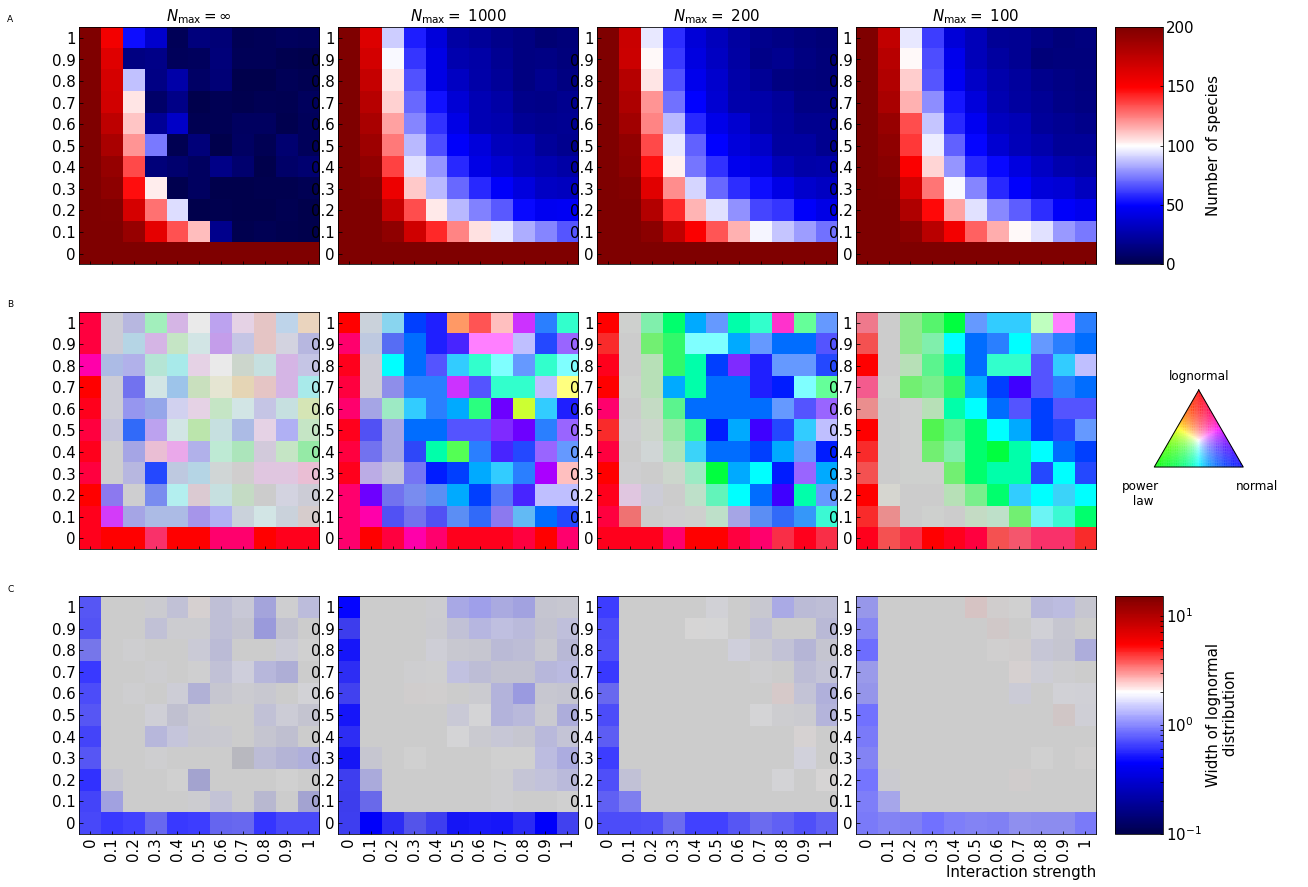

In [70]:
#extra figure 
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    model = 'glv'
    x = 'interaction'; y = 'connectance';
    params = {'immigration' : 0., 'noise' : 0.5}
    figure_changing_maxcap(model, x, y, params, xticklabels='auto', yticklabels='auto', 
                        noise_implementation=NOISE.LANGEVIN_LINEAR)
    #plt.savefig('figures/changing_maxcap.pdf')
    
    #figure_changing_maxcap(model, x, y, params, xticklabels='auto', yticklabels='auto', 
    #                    noise_implementation=NOISE.LANGEVIN_CONSTANT)
    plt.show()

In [44]:
#extra figure ##todo debug (frames not nice)

if False:
    fig = plt.figure(figsize=(ELIFE.TEXTWIDTH, 1.5), tight_layout=True)

    x = 'interaction'; y = 'connectance';
    model = 'glv'

    params = {'immigration' : 0.1, 'noise' : 0.5}

    fig = plt.figure(figsize=(ELIFE.TEXTWIDTH, 1.5), tight_layout=True)
    gs = gridspec.GridSpec(1,4,width_ratios=[5,1,5,1],wspace=0.1,top=0.85,bottom=0.3)

    for ax, ax_cbar, var, dist in zip([fig.add_subplot(gs[0]), fig.add_subplot(gs[2])],
                             [fig.add_subplot(gs[1]), fig.add_subplot(gs[3])],
                             ['width', 'variation_mean'],
                             ['log', None]):
        params['max_cap'] = 100
        mat100 = comparison_matrix(x=x, y=y, var=var, dist=dist, model=model, agg=np.nanmedian, ax=ax, ax_cbar=ax_cbar, params=params)

        params['max_cap'] = 200
        mat200 = comparison_matrix(x=x, y=y, var=var, dist=dist, model=model, 
                                agg=np.nanmedian, ax=ax, ax_cbar=ax_cbar, params=params)

        mat_diff = mat100 - mat200

        im = ax.imshow(mat_diff, cmap='seismic', norm=PiecewiseNormalize([-1.0, 0.0, 0.3], [0, 0.5, 1]))
        plt.colorbar(im, cax=ax_cbar)

    #plt.savefig('figures/changing_maxcap.pdf')
    plt.show()

## Figure 7 : Logistic model 

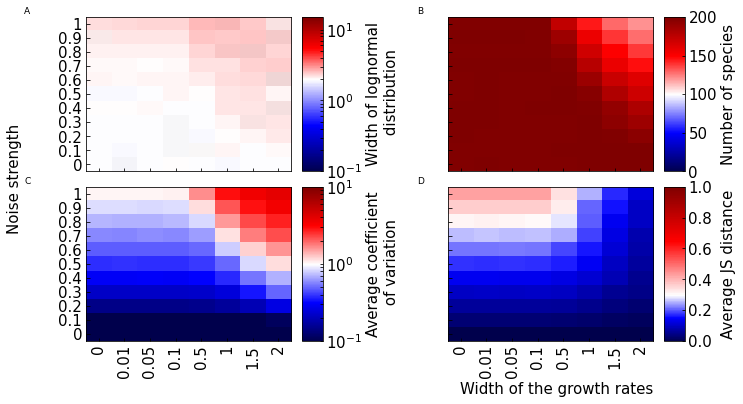

In [71]:
#figure 7
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model = 'logistic'
    x = 'width_growth'; y = 'noise';
    params = {} #

    #xticklabels = ['$10^{-3}$', '', '',
    #                '$10^{-2}$', '', '', '$10^{-1}$', '', '', '2']
    #yticklabels = ['0', '$10^{-3}$', '', '', '',
    #                '$10^{-2}$', '', '', '', '$10^{-1}$', '', '', '', '1']
    xticklabels = 'auto' #None
    yticklabels = 'auto' #None
    
    overview_figure(model, x, y, params, xticklabels, yticklabels)
    #plt.savefig('figures/logistic.pdf')
    
    #overview_figure(model, x, y, params, xticklabels, noise_implementation=NOISE.LANGEVIN_CONSTANT)
    
    plt.show()

# Heavy tails via parameter distributions: Figure 6

In logistic equation the steady state is given by the growth rate divided by the self interaction.

Imagine the the self interaction and the growth rate are uniform distributions between [0, a] and [0, b] respectively. It follows that the distribution of the steady states is

$ f(x) = \frac{1}{2\phi} $ for $ 0 < x < \phi $
and $ f(x) = \frac{\phi}{2 x^2} $ for $ x > \phi $
with $ \phi = b/a $

In [72]:
def ratio_uniform_distributions_1(x, phi):
    if x < 0: 
        return 0
    elif x < phi:
        return 0.5/phi
    else:
        return phi/(2*x**2)

ratio_uniform_distributions = np.vectorize(ratio_uniform_distributions_1) 

def cumulative_ratio_uniform_distributions_1(x, phi):
    if x < 0:
        return 0
    elif x < phi:
        return 0.5/phi*x
    else:
        return 1 - phi/(2*x)

cumulative_ratio_uniform_distributions = np.vectorize(cumulative_ratio_uniform_distributions_1) 
  
class RatioUniformDistributions(stats.rv_continuous):
    def _pdf(self, x, phi):
        return ratio_uniform_distributions(x, phi) 
    
    def _cdf(self, x, phi):
        return cumulative_ratio_uniform_distributions(x, phi)
        
    def _argcheck(self, phi):
        return phi > 0

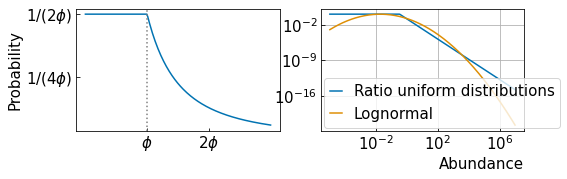

In [73]:
#fig = plt.figure(figsize=(ELIFE.TEXTWIDTH, 1.5))
fig = plt.figure(figsize=(0.6*PRESENTATION.SLIDEWIDTH, 0.3*PRESENTATION.SLIDEHEIGHT))
ax = fig.add_subplot(121)
x = np.linspace(0, 3, 200)
ax.plot(x, ratio_uniform_distributions(x, 1))
ax.axvline(x=1, linestyle=':', color='grey')
ax.set_xticks([1, 2])
ax.set_xticklabels(['$\phi$', '$2\phi$'])
ax.set_yticks([0.25, 0.5])
ax.set_yticklabels(['$1/(4\phi)$', '1/(2$\phi$)'])
ax.set_ylabel('Probability')

ax = fig.add_subplot(122)
x = np.logspace(-5, 7, 300)
ax.plot(x, ratio_uniform_distributions(x, 1/3), label='Ratio uniform distributions')
ax.plot(x, stats.lognorm.pdf(x, 2, 0), label='Lognormal')
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid()
ax.legend()
ax.set_xlabel('Abundance', x=1, ha='right')
#plt.savefig('figures/ratio_uniform_distributions.pdf')
#plt.savefig('../figures_presentation/ratio_uniform_distributions.pdf')
plt.show()

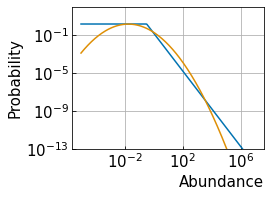

In [74]:
fig = plt.figure(figsize=(0.3*PRESENTATION.SLIDEWIDTH, 0.4*PRESENTATION.SLIDEHEIGHT), tight_layout=True)
ax = fig.add_subplot(111)
x = np.logspace(-5, 7, 300)
ax.plot(x, ratio_uniform_distributions(x, 1/3), label='Ratio uniform distributions')
ax.plot(x, stats.lognorm.pdf(x, 2, 0), label='Lognormal')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-13,1e2])
ax.grid()
#ax.legend()
ax.set_ylabel('Probability')
ax.set_xlabel('Abundance', x=1, ha='right')
#plt.savefig('../figures_presentation/ratio_uniform_distributions.pdf')
plt.show()

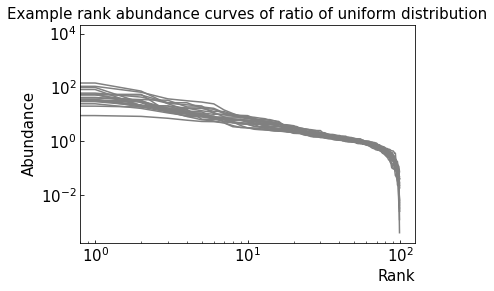

In [75]:
#extra 
plt.title('Example rank abundance curves of ratio of uniform distribution')
N = 100
for i in range(20):
    a = np.random.uniform(0,1,N)
    b = np.random.uniform(0,1,N)
    plt.plot(np.sort(a/b)[::-1], color='grey')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Rank', x=1, ha='right')
plt.ylabel('Abundance')
plt.show()

Does this function fit to experimental data?

Plankton bacteria phi : 8.62E-01 pvalue : 1.23E-03
Plankton eukarya phi : 7.31E-01 pvalue : 4.03E-03
Stool A phi : 9.27E-01 pvalue : 2.55E-01
Stool B phi : 8.51E-01 pvalue : 2.46E-01
Female palm phi : 8.08E-01 pvalue : 3.78E-01
Sanger phi : 6.57E-01 pvalue : 2.67E-03
Illumina phi : 6.49E-01 pvalue : 7.21E-04
Pyroseq phi : 5.06E-01 pvalue : 1.20E-02


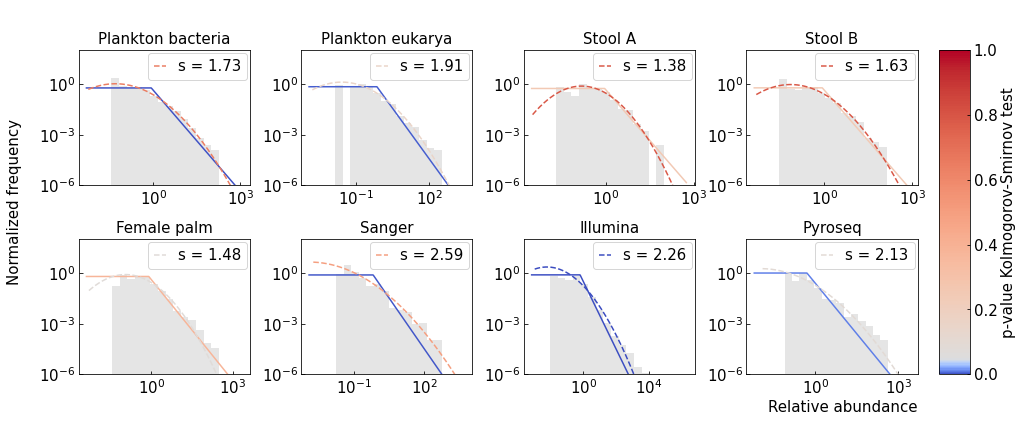

In [77]:
#extra 

bins = np.logspace(-8, -1, 30)
x_fit = np.logspace(-8, -1, 1000)

fig = plt.figure(figsize=(ELIFE.FULLWIDTH*2, 3*2))  # , tight_layout=True)
gs = gridspec.GridSpec(2, 4, bottom=0.1, top=0.85,
                       left=0.1, right=0.9, wspace=0.3, hspace=0.4)
gs_cbar = gridspec.GridSpec(1, 1, bottom=0.1, top=0.85, left=0.92, right=0.95)
gs_tot = gridspec.GridSpec(1, 1, bottom=0.05, top=0.95, left=0.05, right=0.9)

keys = ['plankton_bacteria', 'plankton_eukarya', 'David_stool_A', 'David_stool_B',
        'Caporaso_F4_L_palm_L6', 'Sanger', 'Illumina', 'Pyroseq']

titles = ['Plankton bacteria', 'Plankton eukarya', 'Stool A', 'Stool B',
          'Female palm', 'Sanger', 'Illumina', 'Pyroseq']

for i, key, title in zip(range(len(keys)), keys, titles):
    ax = fig.add_subplot(gs[i])
    ax.set_title(title)

    if key in df_ts:
        d = np.copy(df_ts[key].values[0, 1:])
    elif key in df_st:
        d = np.copy(df_st[key].values[0, 1:])
    
    # rescale
    d = d[d > 0]    
    d /= 10**np.mean(np.log10(d))
    
    phi = np.median(d)
    rud = RatioUniformDistributions(name='rud')
    
    bins = np.logspace(np.log10(np.min(d))-1, np.log10(np.max(d))+1, 21)
    x_fit = np.logspace(np.log10(np.min(d))-1, np.log10(np.max(d))+1, 500)
    
    cmap = plt.cm.get_cmap('coolwarm')
    norm = normalizations['pval']
    
    stat, pval = stats.kstest(d, rud._cdf, args=((phi,)))
    ax.plot(x_fit, ratio_uniform_distributions(x_fit, phi), color=cmap(norm(pval)))
    print(title, 'phi : %.2E' % phi, 'pvalue : %.2E' % pval)
    
    pars = fit_heavytail(d)
    plot_heavytail(d, pars, ax=ax, linestyle='--')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim([1e-6, 1e2])

ax_cbar = fig.add_subplot(gs_cbar[0])
mcolorbar.ColorbarBase(ax_cbar, cmap=plt.cm.coolwarm,
                       orientation='vertical', norm=normalizations['pval'])

ax_cbar.set_ylabel('p-value Kolmogorov-Smirnov test')
ax = fig.add_subplot(gs_tot[:], frameon=False)
ax.tick_params(axis='both', left=False, labelleft=False,
               bottom=False, labelbottom=False)
ax.set_xlabel('Relative abundance', ha='right', x=1)
ax.set_ylabel('Normalized frequency')

#plt.savefig('figures/experimental_rud.pdf')
plt.show()

In [59]:
# extra results in RAD of noninteracting deterministic systems (logistic) (see github Lana)